# Feature Occurrence Data Noise Inducers

This notebook details strategies to augment our feature occurrence data (datasets of 0's and 1's) and create artificial samples without recourse to Deep Learning and GANs. These strategies were made using empirical knowledge to create rules to make them. It then compares these artificial feature occurrence data to the experimental data to see how closely it simulates it. Finally, a method for intensity imputation on the feature occurrence data was also made to also create intensity (non-treated) data.

These methods worked by 'inducing noise' on the experimental data to create new data.

As an example, the grapevine dataset 'vitis_types' is used.

Notebook organization:
- Example of Noise Inducers on a single sample
- Application of Noise Inducing to a full dataset of Feature Occurrence Data
- Impute intensity values on the Generated Feature Occurrence Data obtained
- Analyze the Intensity and Feature Occurrence Generated Data compared to the experimental Grapevine Data

#### Needed Imports

In [1]:
from pathlib import Path
import json
from time import perf_counter
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import multianalysis as ma
import gan_evaluation_metrics as gem

import metabolinks.transformations as transf

# Python files in the repository
import linear_augmentation_functions as laf

In [2]:
%matplotlib inline

Reading the data

In [3]:
path = Path.cwd() / "store_data" / 'processed_data.json'
storepath = Path.cwd() / "store_data" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        dataset['iter_fold_splits'] = {}
        for key in dataset:
            if 'iter_fold_splits' == key:
                continue
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                # Load the data from 'iter_fold_splits' carefully restoring the nested dictionaries
                if len(storekey.split("AA_")) > 1: # This separation was made to identify the 'iter_fold_splits' data
                    dictkeys = (storekey.split("AA_")[1]).split('_',3)
                    if int(dictkeys[0]) not in dataset['iter_fold_splits'].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])] = {}
                    if dictkeys[1] not in dataset['iter_fold_splits'][int(dictkeys[0])].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]] = {}
                    if int(dictkeys[2]) not in dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])] = {}
                    dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = store[storekey]

                else:
                    dataset[key] = store[storekey]
                
            # convert colors to tuples, since they are read as lists from json file
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]
            elif key.endswith('target') and key.startswith(dskey):
                dictkeys = ((key.split("_", 1)[1]).split("AA_")[1]).split('_',3)
                dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = value

### Testing options for noise inducing on feature occurrence data

Creating a test_sample and then apply each noise inducer method with noise_fraction = 0.10. These methods started by the most simple and were evolved taking more factors and possibilities into account, generating what we consider to be the two best methodologies.

#### Different methods (more information about them in linear_augmentation_functions.py)

- i_rs_cf_dist
- i_fs_cf_dist

These two methods differ in how they 'choose' which features to induce noise to generate the artificial data both having the critic argument 'noise_fraction'. 'rs' means random sampling, here the noise_fraction is a threshold and each feature is randomly given a value. If it is below the threshold, the feature changes from 1 to 0 (or vice-versa); if not, the value stays the same. This means that the number of features that change is not fixed and may suffer fluctuations based on the random values assigned to each feature. 'fs' means fixed sampling, here the noise_fraction represents the actual fraction of features that will be changed from 1 to 0 or vice-versa; thus the number of changed features is fixed.

'i' refers to imbalanced. In most datasets, the number of missing values isn't approximately the same to the number of present values. For example, if there are much more missing values than present values, choosing values at random would change many more missing values to 1 than present values to 0. This would create artificial samples with many more present values than experimental data. To avoid this, noise_fraction chosen is chosen for the '1' values (that may change into '0') and another parameter is calculated from the noise_fraction to change, on average, the same number of '0' values (into '1's).

'cf' or change_factor is just a parameter where randomly, either 1s or 0s, have their noise_fraction value multiplied bu the change_factor. This is to use if the user wants more severe changes to the artificial data.

'dist' or distribution means that the likelihood a value changing depends on how many of the experimental data that feature has the original value. That is, a feature that is 1 in almost all samples of a class should probably also have a 1 in an artificial sample of that class since that feature seems characteristic of it, thus, the chances that it changes are much lower compared to a feature that is 1 in the base sample where noise is being induced but is only a 1 in around half of the samples of that class.

In [4]:
# Linearly generated sample to use as an example sample
test_sample = laf.artificial_binary_sample_generator(
    datasets['vitis_types']['BinSim'].iloc[0], datasets['vitis_types']['BinSim'].iloc[1], method='random sampling')

Testing all methods developed on the base sample 50 times and analysing their characteristics

In [5]:
results = {'i_rs':[], 'i_fs':[], 'rs':[], 'fs':[], 'fsv':[], 'i_rs_cf':[], 'i_fs_cf': [], 'i_rs_cf_dist':[], 
           'i_fs_cf_dist':[]}
for _ in range(50):
    results['i_rs'].append(laf.imbalanced_noise_inducer(test_sample, noise_fraction=0.10, method='random sampling'))
    results['i_fs'].append(laf.imbalanced_noise_inducer(test_sample, noise_fraction=0.10, method='fixed sampling'))
    results['rs'].append(laf.noise_inducer(test_sample, noise_fraction=0.10, method='random sampling'))
    results['fs'].append(laf.noise_inducer(test_sample, noise_fraction=0.10, method='fixed sampling'))
    results['fsv'].append(laf.noise_inducer(test_sample, noise_fraction=0.10, method='fixed sampling by value'))

    results['i_rs_cf'].append(laf.imbalanced_noise_inducer(
        test_sample, noise_fraction=0.10, method='random sampling', noise_fraction_changer=True))
    results['i_fs_cf'].append(laf.imbalanced_noise_inducer(
        test_sample, noise_fraction=0.10, method='fixed sampling', noise_fraction_changer=True))
    
    results['i_rs_cf_dist'].append(laf.imbalanced_noise_inducer(
        test_sample, noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
        data = datasets['vitis_types']['BinSim']))
    
    results['i_fs_cf_dist'].append(laf.imbalanced_noise_inducer(
        test_sample, noise_fraction=0.10, method='fixed sampling', noise_fraction_changer=True,
        data = datasets['vitis_types']['BinSim']))

In [6]:
sums = {'i_rs':[], 'i_fs':[], 'rs':[], 'fs':[], 'fsv':[], 'i_rs_cf':[], 'i_fs_cf': [], 'i_rs_cf_dist':[],
        'i_fs_cf_dist':[]}
dissimilarity = {'i_rs':[], 'i_fs':[], 'rs':[], 'fs':[], 'fsv':[], 'i_rs_cf':[], 'i_fs_cf': [], 'i_rs_cf_dist':[],
                 'i_fs_cf_dist':[]}
for i in results:
    for j in results[i]:
        sums[i].append(j.sum())
        dissimilarity[i].append((j != test_sample).sum() / len(test_sample))

Plotting the results

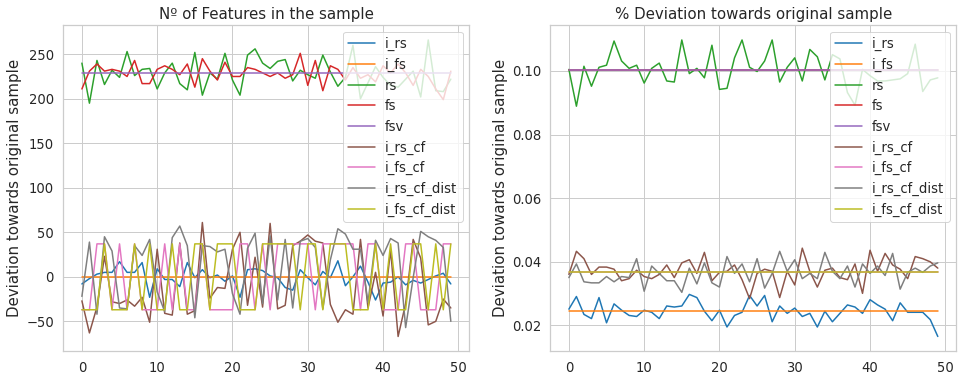

In [7]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        for i in results:
            axl.plot(sums[i] - test_sample.sum(), label=i)
            axr.plot(dissimilarity[i], label=i)

        axl.set_title('Nº of Features in the sample', fontsize=15)
        axl.set_ylabel('Deviation towards original sample', fontsize=15)
        
        axr.set_title('% Deviation towards original sample', fontsize=15)
        axr.set_ylabel('Deviation towards original sample', fontsize=15)
        
        axl.legend()
        axr.legend()

## Inducing noise in a full dataset

#### Conditional Noise Inducing based on labels should be considered

In [8]:
start = perf_counter()
data_bin, lbls_bin = laf.artificial_dataset_generator(datasets['vitis_types']['BinSim'], labels=datasets['vitis_types'][
    'target'], max_new_samples_per_label=512, binary='random sampling', rnd=list(np.linspace(0.1,0.9,9)), 
                                        binary_rnd_state=None, rnd_state=None)
end = perf_counter()
print(f'Simple augmentation of data done! took {(end - start):.3f} s')

Simple augmentation of data done! took 118.679 s


In [9]:
data_bin

,97.588680,97.588790,97.588890,97.589990,97.590205,97.591880,98.348930,98.350780,98.351215,98.352190,...,965.863830,965.921180,965.989930,966.003140,966.006120,966.054730,966.057615,966.144500,966.244942,977.114775
"Arti ('RL', '26')-('RL', '28')_rnd0.2",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('PN', '24')-('RL', '28')_rnd0.7",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('RL', '26')-('TRI', '32')_rnd0.4",1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('CS', '30')-('CS', '31')_rnd0.1",0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('PN', '23')-('TRI', '32')_rnd0.7",1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('SYL', '11')-('SYL', '13')_rnd0.5",0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('SYL', '11')-('SYL', '12')_rnd0.3",0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('CAN', '15')-('SYL', '13')_rnd0.1",0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('CAN', '14')-('LAB', '9')_rnd0.4",0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
base_df = data_bin.copy()
#results = {'real_data':datasets['vitis_types']['BinSim'], 'data_bin': data_bin,
results = {'data_bin': data_bin,
           'i_rs':base_df.copy(), 'i_fs':base_df.copy(), 'rs':base_df.copy(), 'fs':base_df.copy(), 'fsv':base_df.copy(),
           'i_rs_cf':base_df.copy(), 'i_fs_cf':base_df.copy(), 'i_rs_cf_dist':base_df.copy(), 'i_fs_cf_dist':base_df.copy()}
    
for i in tqdm(range(len(data_bin.index))):
    results['i_rs'].iloc[i] = laf.imbalanced_noise_inducer(data_bin.iloc[i], noise_fraction=0.10, method='random sampling')
    results['i_fs'].iloc[i] = laf.imbalanced_noise_inducer(data_bin.iloc[i], noise_fraction=0.10, method='fixed sampling')
    results['rs'].iloc[i] = laf.noise_inducer(data_bin.iloc[i], noise_fraction=0.10, method='random sampling')
    results['fs'].iloc[i] = laf.noise_inducer(data_bin.iloc[i], noise_fraction=0.10, method='fixed sampling')
    results['fsv'].iloc[i] = laf.noise_inducer(data_bin.iloc[i], noise_fraction=0.10, method='fixed sampling by value')

    results['i_rs_cf'].iloc[i] = laf.imbalanced_noise_inducer(
        data_bin.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True)
    results['i_fs_cf'].iloc[i] = laf.imbalanced_noise_inducer(
        data_bin.iloc[i], noise_fraction=0.10, method='fixed sampling', noise_fraction_changer=True)
    
    # For the methods that account for the number of times a feature appears in a sample of a class
    # Reduce dataset for only the sample of the class
    if lbls_bin[i] == 'wild':
        results['i_rs_cf_dist'].iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
            data = datasets['vitis_types']['BinSim'].loc[np.array(datasets['vitis_types']['target'])=='wild'])
        
        results['i_fs_cf_dist'].iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='fixed sampling', noise_fraction_changer=True,
            data = datasets['vitis_types']['BinSim'].loc[np.array(datasets['vitis_types']['target'])=='wild'])
    else:
        results['i_rs_cf_dist'].iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
            data = datasets['vitis_types']['BinSim'].loc[np.array(datasets['vitis_types']['target'])=='vinifera'])
        
        results['i_fs_cf_dist'].iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='fixed sampling', noise_fraction_changer=True,
            data = datasets['vitis_types']['BinSim'].loc[np.array(datasets['vitis_types']['target'])=='vinifera'])

  0%|          | 0/1024 [00:00<?, ?it/s]

In [11]:
def characterize_binary_data(dataset, name='dataset', target=None):
    "Returns some basic characteristics about the dataset."
    
    n_samples, n_feats = dataset.shape
    
    if target:
        n_classes = len(np.unique(target))
        Samp_Class = len(target)/len(np.unique(target)) # Number of Sample per Class
    
    max_n_features = dataset.sum(axis=1).max() # Nº of features of sample with the most features
    min_n_features = dataset.sum(axis=1).min() # Nº of features of sample with the least features
    avg_n_features = round(dataset.sum(axis=1).mean(),2) # Average number of features of a sample
    std_n_features = round(dataset.sum(axis=1).std(),2) # Standard Deviation of the number of features per sample
    median_n_features = np.median(dataset.sum(axis=1)) # Median number of features of a sample
    
    min_n_samples = dataset.sum(axis=0).min() # Minimum nº of samples a feature appears
    max_n_samples = dataset.sum(axis=0).max() # Maximum nº of samples a feature appears
    avg_n_samples = round(dataset.sum(axis=0).mean(),2) # Average number of samples a feature appears in
    std_n_samples = round(dataset.sum(axis=0).std(),2) # Standard Deviation of the number of samples a feature appears in
    
    if target:
        return {'Dataset': name,
                '# samples': n_samples,
                '# features': n_feats,
                'average # of features per sample (std)': f'{avg_n_features} ({std_n_features})',
                '# features per sample ranges': f'({min_n_features} - {max_n_features})',
                '# features per sample median': median_n_features,
                'average # of times feature appear in sample (std)': f'{avg_n_samples} ({std_n_samples})',
                'min and max # of times a feature appears in a sample': f'{min_n_samples} - {max_n_samples}',
                '# classes': n_classes,
                'samples / class': Samp_Class,
                } 
    else:
        return {'Dataset': name,
                '# samples': n_samples,
                '# features': n_feats,
                'average # of features per sample (std)': f'{avg_n_features} ({std_n_features})',
                '# features per sample ranges': f'({min_n_features} - {max_n_features})',
                '# features per sample median': median_n_features,
                'average # of times feature appear in sample (std)': f'{avg_n_samples} ({std_n_samples})',
                'min and max # of times a feature appears in a sample': f'{min_n_samples} - {max_n_samples}',
                }

In [12]:
tg = lbls_bin
data_characteristics = [characterize_binary_data(ds, name, tg) for name,ds in results.items()]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,average # of features per sample (std),# features per sample ranges,# features per sample median,average # of times feature appear in sample (std),min and max # of times a feature appears in a sample,# classes,samples / class
Dataset,,,,,,,,,
data_bin,1024,3026,551.82 (133.8),(339.0 - 918.0),519.5,186.74 (182.65),41.0 - 1024.0,2,512.0
i_rs,1024,3026,551.44 (134.16),(332.0 - 935.0),517.5,186.61 (160.29),56.0 - 934.0,2,512.0
i_fs,1024,3026,551.83 (133.8),(339.0 - 918.0),519.5,186.74 (160.3),54.0 - 937.0,2,512.0
rs,1024,3026,744.08 (108.93),(565.0 - 1045.0),724.5,251.8 (146.39),120.0 - 931.0,2,512.0
fs,1024,3026,744.43 (107.32),(578.0 - 1053.0),721.0,251.92 (146.29),116.0 - 932.0,2,512.0
fsv,1024,3026,744.06 (107.05),(574.0 - 1037.0),718.5,251.79 (146.23),124.0 - 933.0,2,512.0
i_rs_cf,1024,3026,547.93 (141.74),(311.0 - 999.0),525.5,185.42 (148.68),61.0 - 881.0,2,512.0
i_fs_cf,1024,3026,550.32 (144.44),(305.0 - 996.0),524.0,186.23 (149.12),56.0 - 894.0,2,512.0
i_rs_cf_dist,1024,3026,553.53 (146.48),(305.0 - 995.0),524.0,187.31 (162.97),49.0 - 1011.0,2,512.0


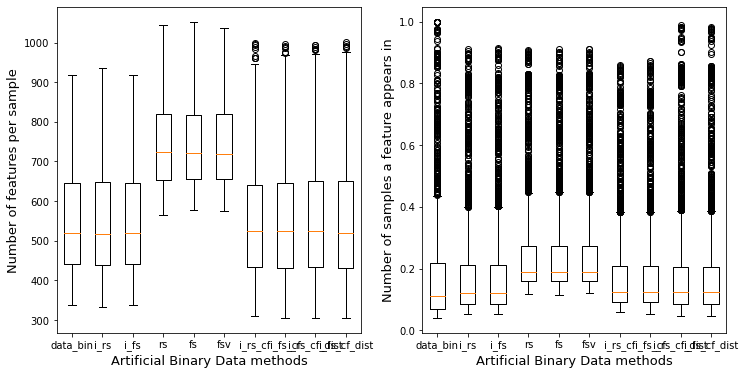

In [13]:
f, (axl, axr) = plt.subplots(1,2, figsize=(12,6))

axl.boxplot([ds.sum(axis=1) for name,ds in results.items()])
axl.set_xlabel('Artificial Binary Data methods', fontsize=13)
axl.set_ylabel('Number of features per sample', fontsize=13)
axl.set_xticklabels(results.keys())

axr.boxplot([ds.sum(axis=0)/len(ds) for name,ds in results.items()])
axr.set_xlabel('Artificial Binary Data methods', fontsize=13)
axr.set_ylabel('Number of samples a feature appears in', fontsize=13)
axr.set_xticklabels(results.keys())

plt.show()

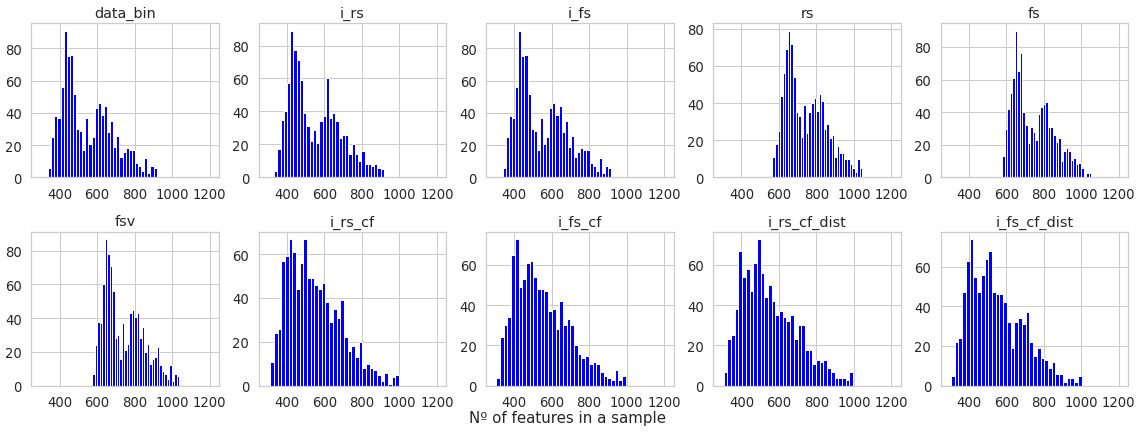

In [14]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axs = plt.subplots(2, 5, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        for i, ax in zip(results, axs.ravel()):
            n_bins = 34
            ax.hist(results[i].sum(axis=1), bins=35, color='blue')
            ax.set_title(i)
            ax.set_xlim(250,1250)

        plt.tight_layout()

    f.text(0.5, 0.03, 'Nº of features in a sample', ha='center', va='top', fontsize=15)

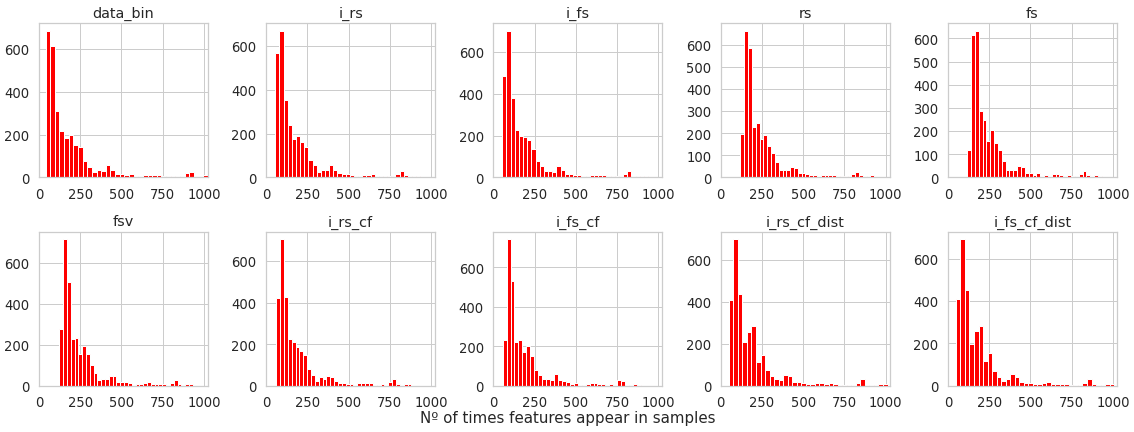

In [15]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axs = plt.subplots(2, 5, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        for i, ax in zip(results, axs.ravel()):
            n_bins = 34
            ax.hist(results[i].sum(axis=0), bins=35, color='red')
            ax.set_title(i)
            ax.set_xlim(0,1024)
        
        #axs[0][0].set_xlim(0,33)
        plt.tight_layout()

    f.text(0.5, 0.03, 'Nº of times features appear in samples', ha='center', va='top', fontsize=15)

### PCA Representation of Experimental and Induced Noise Data (Feature Occurrence Data)

In [16]:
# Joining the datasets
joined_dfs_bin = pd.concat([datasets['vitis_types']['BinSim'], data_bin])
joined_labels = datasets['vitis_types']['target'].copy() + [i + '_gen' for i in lbls_bin]

In [17]:
joined_dfs_bin_rev = pd.concat([data_bin, datasets['vitis_types']['BinSim']])
joined_labels_rev = [i + '_gen' for i in lbls_bin] + datasets['vitis_types']['target'].copy()

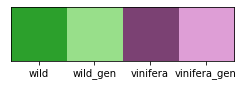

In [18]:
colours = sns.color_palette('tab20', 6)[4:]
colours.append(sns.color_palette('tab20b', 18)[16])
colours.append(sns.color_palette('tab20b', 20)[19])

ordered_labels = ('wild','wild_gen','vinifera','vinifera_gen')
label_colors = {lbl: c for lbl, c in zip(ordered_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(ordered_labels)), ordered_labels)

In [19]:
def plot_PCA(principaldf, label_colors, components=(1,2), title="PCA", ax=None):
    "Plot the projection of samples in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PCA(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot confidence ellipses of a class' samples based on their projection in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')


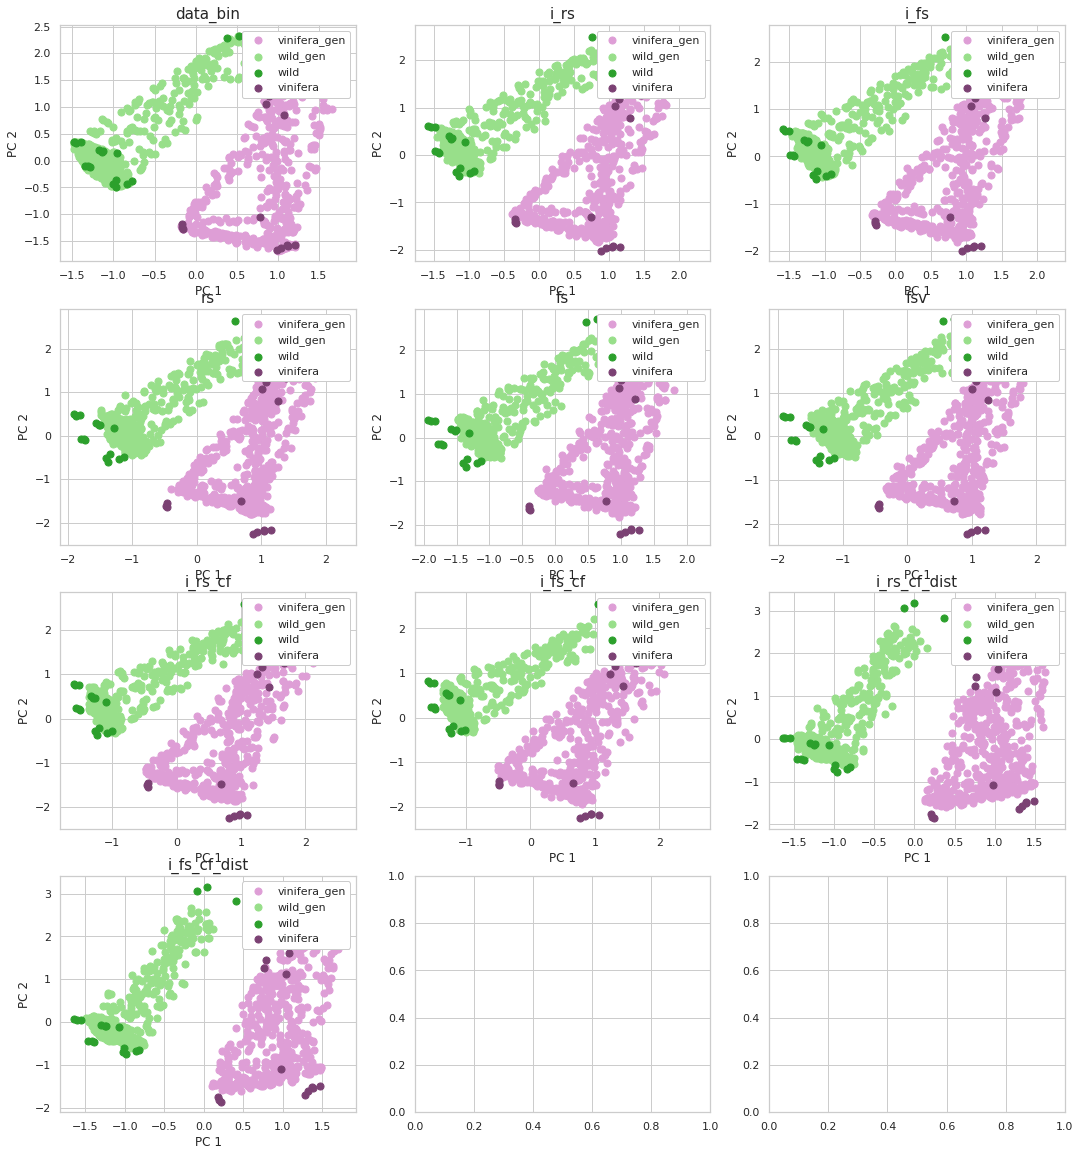

In [20]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(4, 3, figsize = (18,20))
        #f, (axl,axr) = plt.subplots(1,2, figsize=(16,6), constrained_layout=True)
        results_temp = results.copy()
        #results_temp.pop('real_data')
        
        for i, ax in zip(results_temp, axs.ravel()):
            df = pd.concat([results[i], datasets['vitis_types']['BinSim']])
            labels = joined_labels_rev

            principaldf = ma.compute_df_with_PCs(df, n_components=2, whiten=True, labels=labels, return_var_ratios=False)
            lcolors = label_colors
            plot_PCA(principaldf, lcolors, components=(1,2), title=i, ax=ax)
            ax.legend(loc='upper right', ncol=1, framealpha=1)

### tSNE plots

In [21]:
from sklearn.manifold import TSNE
def plot_tSNE(embedded_df, labels, label_colors, components=(1,2), title="tSNE", ax=None):
    "Plot the projection of samples in the 2 main dimensions of a tSNE model."
    
    if ax is None:
        ax = plt.gca()

    #ax.axis('equal')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    unique_labels = set(labels)

    for lbl in unique_labels:
        subset = embedded_df[[i==lbl for i in labels]]
        ax.scatter(subset[:,0],
                   subset[:,1],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)
    
def plot_ellipses_tSNE(embedded_df, labels, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot confidence ellipses of a class' samples based on their projection in the 2 main dimensions of a tSNE model."
    
    if ax is None:
        ax = plt.gca()
    
    #ax.axis('equal')

    unique_labels = set(labels)

    for lbl in unique_labels:
        subset_points = embedded_df[[i==lbl for i in labels]]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')


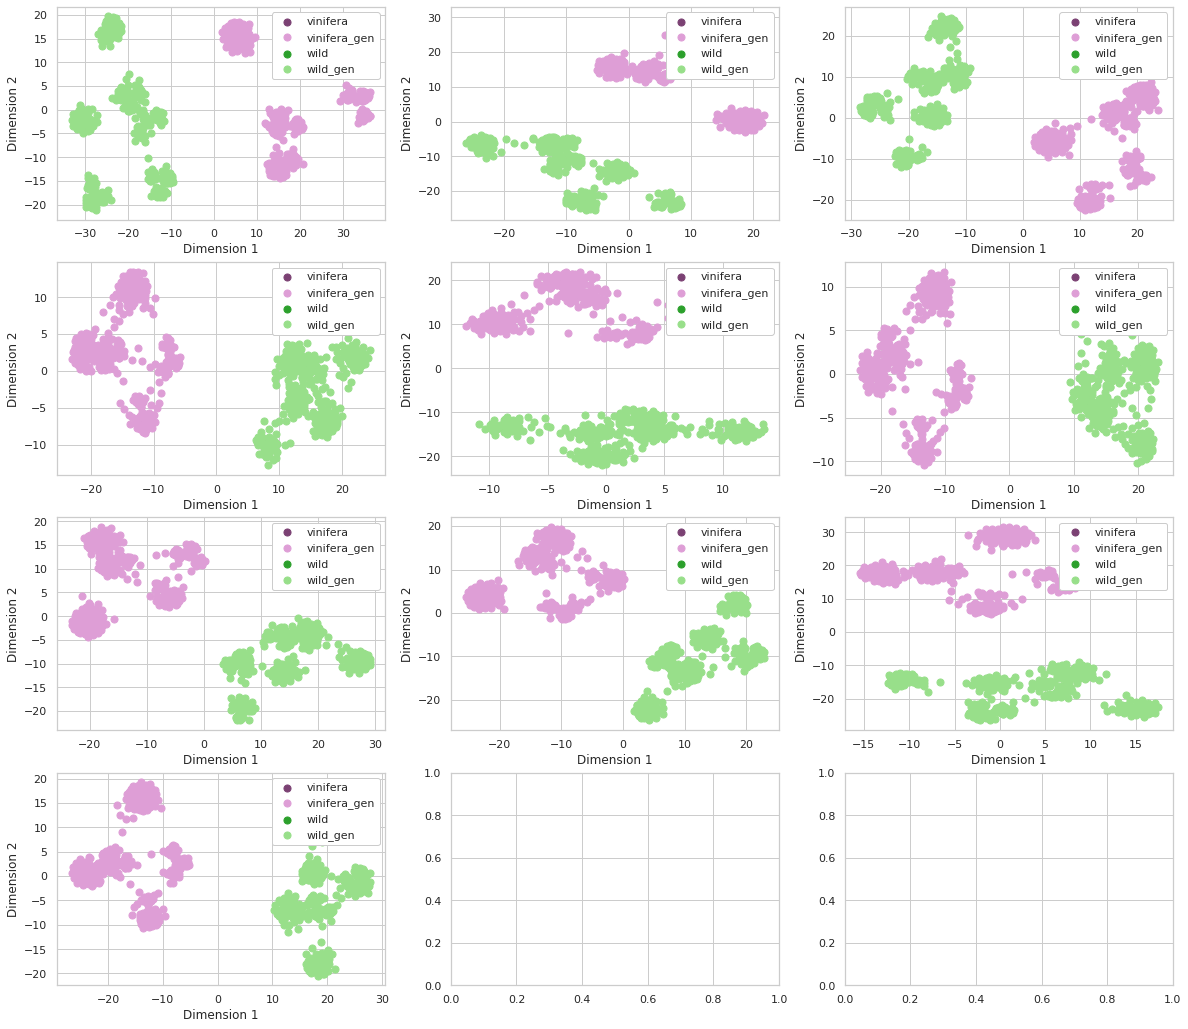

In [22]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(4, 3, figsize = (20,18))
        #f, (axl,axr) = plt.subplots(1,2, figsize=(16,6), constrained_layout=True)
        results_temp = results.copy()
        #results_temp.pop('real_data')
        
        for i, ax in zip(results_temp, axs.ravel()):
            X = pd.concat([results[i], datasets['vitis_types']['BinSim']])
            labels = joined_labels_rev
            
            df = TSNE(n_components=2, perplexity=40, learning_rate='auto',
                      init='random').fit_transform(X)
            lcolors = label_colors
            plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=ax)
            ax.legend(loc='upper right', ncol=1, framealpha=1)


Example of the distribution used for the samples of the 'wild' class of the GD dataset.

- Blue Histogram - Distribution of the number of samples each feature appears in.

- Orange - Uniform Distribution (probability of a feature being changed is independent.
- Blue - Normal Distribution with average on half of the total samples of a class in the dataset and standard deviation equal to the standard deviation of the distribution of the number of samples each feature appears in. This distributon represents the relative probability that a feature is changed from 1 to 0 (and vice-versa) based on the number of samples each feature appears in.

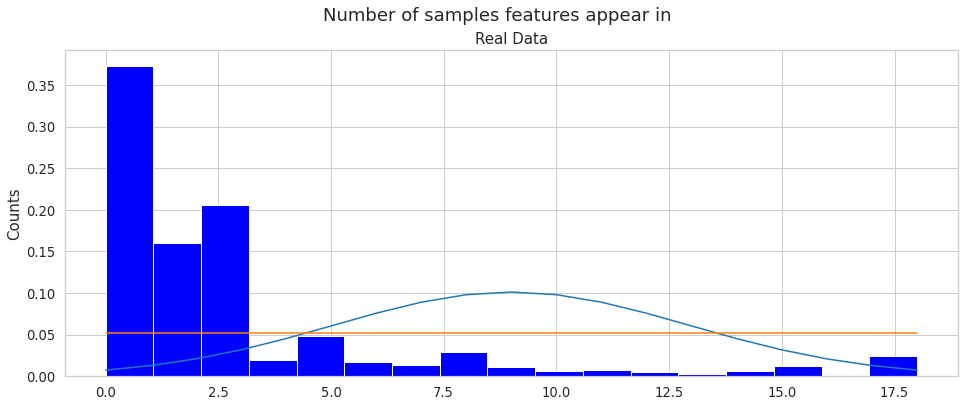

In [23]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        df_temp = datasets['vitis_types']['BinSim'][[i=='wild' for i in datasets['vitis_types']['target']]]
        ax.hist(df_temp.sum(axis=0), bins=17, color='blue', density=True)
        ax.set_title('Real Data', fontsize=15)
        ax.set_ylabel('Counts', fontsize=15)
        
        thing = df_temp.sum(axis=0)
        x = range(int(np.min(thing)), int(np.max(thing)+1))
        mu = int(np.max(thing))/2
        std = np.std(thing)
        pdf = stats.norm(mu,std).pdf(x)
        ax.plot(x, pdf)
        ax.plot(x, [np.mean(pdf)]*len(x))
        
        plt.suptitle('Number of samples features appear in', fontsize=18)

### Entering Intensity values in the Feature Occurrence matrices created

The idea is to take a distribution of intensities of all values in the dataset after normalization. Then, to impute each feature, see the minimum and maximum intensity values for that feature in the real samples of a class. Taking an extra margin below the minimum and above the maximum, the original distribution is truncated and a random values is drawn from the distribution. 

If, by chance, a feature appears in a sample while not appearing in any of the real samples of that class (rare), the minimum is the lowest intensity value in the dataset and the maximum is the median of the values in the dataset. The rationale is that if a feature is that rare in a class, it would not have a high intensity value (this also stops the appearance of very high disproportionate values in the dataset after scaling). Higher intensity features would appear more often in other samples of the same class.

In [24]:
# Real Data to compare with the artificial data
data_NGP = pd.read_csv('store_data/generated_data_NGP.csv')
data_NGP = data_NGP.set_index(data_NGP.columns[0])
data_NGP

,97.58868,97.58879,97.58889,97.58999,97.590205,97.59188,98.34893,98.35078,98.351215,98.35219000000001,...,965.86383,965.92118,965.98993,966.00314,966.00612,966.0547300000001,966.0576149999999,966.1445,966.2449425,977.114775
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
"Arti ('CS', '30')-('TRI', '32')_rnd0.7",2.051156,-0.135816,0.576759,1.983498,0.836729,1.454090,-0.333780,-0.374566,-0.226361,-0.386231,...,-0.219968,-0.116664,2.685999,-0.211282,2.114339,-0.189629,-0.195694,1.427163,-0.390348,-0.096093
"Arti ('CS', '29')-('CS', '31')_rnd0.6",-0.713102,0.083884,1.618778,-0.449004,1.855094,1.091408,-0.149441,-0.198260,-0.031607,1.142061,...,-0.001199,2.972244,-0.208685,-0.018887,2.492278,0.014498,0.012669,1.973523,-0.192801,0.130951
"Arti ('CS', '30')-('PN', '23')_rnd0.3",-0.598649,0.223000,1.843113,-0.322997,2.044035,0.958650,-0.032716,-0.086622,0.091713,-0.030870,...,0.137327,0.236007,-0.088394,0.102940,3.391391,0.143752,0.144606,2.697599,-0.067712,0.274718
"Arti ('CS', '29')-('REG', '40')_rnd0.8",1.114645,-0.341370,-0.223700,0.828057,0.014583,-0.834432,2.434333,2.549629,2.817304,-0.243705,...,-0.424650,1.056262,-0.576393,-0.391289,1.395216,2.734390,-0.390641,0.892483,2.052133,1.871917
"Arti ('CS', '29')-('CS', '31')_rnd0.8",-0.622773,0.193678,1.708646,-0.349557,1.959777,1.231484,-0.057319,-0.110153,0.065720,1.277207,...,0.108128,2.984651,-0.113749,0.077261,1.875068,0.116508,0.116797,1.436510,-0.094078,0.244415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('ROT', '22')-('RU', '36')_rnd0.3",0.095565,-0.309794,-1.446677,-0.016609,-0.810522,-1.583022,-0.479756,-0.514181,-0.380585,0.727563,...,-0.393208,-0.287663,-0.549090,-0.363638,-0.366225,-0.351274,2.019488,-0.285196,1.307463,-0.275887
"Arti ('CAN', '16')-('SYL', '11')_rnd0.3",-1.490968,-0.861596,1.379289,-1.305394,0.339245,0.701965,-0.942744,-0.956992,-0.869733,-1.105022,...,-0.942670,-0.830016,-1.026221,-0.846860,-0.860863,-0.863960,-0.884021,-0.846025,-1.042947,-0.846134
"Arti ('LAB', '9')-('RU', '37')_rnd0.2",-0.266956,-0.454805,0.526619,-0.252122,-0.949748,-0.018375,-0.601427,-0.630549,-0.509131,0.447575,...,-0.537603,-0.430191,-0.674477,-0.490626,-0.496213,-0.486005,-0.498221,-0.432579,-0.677173,-0.425745


In [25]:
# Normalize the Experimental data
norm = transf.normalize_ref_feature(datasets['vitis_types']['data'], 554.26202, remove=True)
#norm

C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)


**Example of imputing intensity in a feature** - 97.591880 (no regard for the class of the sample in this example)

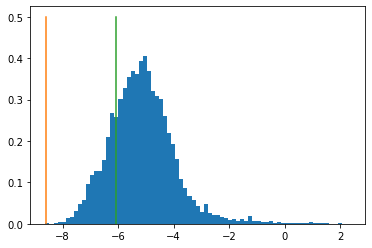

In [26]:
# Distribution of intensities in the original data and minimum and maximum of a feature
plt.hist(np.log(norm.values.flatten()), bins=75, density=True)
plt.plot([min(np.log(norm[97.591880])), min(np.log(norm[97.591880]))], [0,0.5])
plt.plot([max(np.log(norm[97.591880])), max(np.log(norm[97.591880]))], [0,0.5])

plt.show()

In [27]:
flat_values = norm.values.flatten()
hist = np.histogram(np.log(flat_values[~np.isnan(flat_values)]), bins=75, density=True)
realdata_dist = stats.rv_histogram(hist)

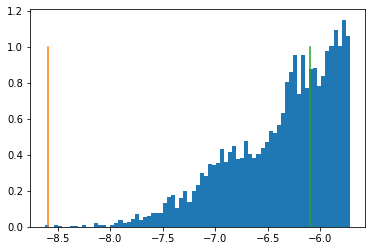

In [28]:
# Selection of intensities near the lowest and highest intensities
flat_values_red = np.log(flat_values[~np.isnan(flat_values)])
mini = min(np.log(norm[97.591880]))
maxi = max(np.log(norm[97.591880]))
dif = 0.15*(maxi-mini)

hist_values = flat_values_red[np.where((flat_values_red > mini-dif) & (flat_values_red < maxi+dif))]

plt.hist(hist_values, bins=75, density=True)
plt.plot([min(np.log(norm[97.591880])), min(np.log(norm[97.591880]))], [0,1])
plt.plot([max(np.log(norm[97.591880])), max(np.log(norm[97.591880]))], [0,1])
#plt.
plt.show()

Make sure every artificial data has the leucine enkephalin peak

In [29]:
for i in results:
    results[i].loc[:,554.26202].replace({0.0:1.0}, inplace=True)
    print(results[i].loc[:,554.26202].sum())

1024.0
1024.0
1024.0
1024.0
1024.0
1024.0
1024.0
1024.0
1024.0
1024.0


**Function to impute intensity values**

In [30]:
def impute_intensity_values(df_bin, orig_data, labels=None, orig_labels=None):
    """From a binary dataframe impute intensities and missing values in 1 and 0 values, respectively.
       
       This is done according to the distributions of intensity in an original reference dataset.
       
       df_bin: Pandas DataFrame; data with binary data
       orig_data: Pandas DataFrame; original data with intensity
       labels: list; list of labels for each sample in the binary data; if None, the label '' is give to every sample
       orig_labels: list; list of labels for each samples in the original data with intensity; if None, the label '' is 
    give to every sample

       returns: Pandas DataFrame; binary dataset imputed with intensity values
       """
    df_int = pd.DataFrame(columns=df_bin.columns, index=data_bin.index)
    if labels == None:
        labels = ['']*len(df_bin)
        orig_labels = ['']*len(orig_data)

    df_int = pd.DataFrame(columns=df_bin.columns, index=data_bin.index) # DataFrame to put the intensity values
    
    # For each different class in the dataset
    for lbl in set(labels):
        
        df_orig = orig_data[[i==lbl for i in orig_labels]] # Reduce dataframe to samples of a label

        flat_values = df_orig.values.flatten() # Get the distribution of values of intensity in that label
        flat_values_red = np.log(flat_values[~np.isnan(flat_values)]) # Logarithmic distribution
        
        for i in df_bin[[i==lbl for i in labels]].columns:
            # See if the feature appears at least one time in the artificial dataset for the class of the aritificial sample
            if df_bin[[i==lbl for i in labels]][i].sum() == 0:
                continue

            # If a feature has different minimum and maximum (appears more than 1) in the real samples of the class
            if df_orig[i].notnull().sum() > 1:
                mini = np.log(df_orig[i]).min()
                maxi = np.log(df_orig[i]).max()
                dif = 0.15*(maxi-mini)
                #print(mini, maxi, dif)
            
            # If a feature has the same minimum and maximum (appears only once) in the real samples of the class
            elif df_orig[i].notnull().sum() == 1:
                mini = np.log(df_orig[i]).min()
                maxi = np.log(df_orig[i]).max()
                dif = 0.15*maxi
                #print(1, mini,maxi,dif)
            
            # If a feature does not appear in the real samples of the class
            elif df_orig[i].notnull().sum() == 0:
                mini = np.log(df_orig).min().min()
                #maxi = np.log(df_orig).max().max()
                maxi = np.median(flat_values_red)
                dif = 0
                #print(0, mini,maxi,dif)
            
            # Truncate the histogram values based on the minimum and maximum (and allowed extra margin)
            hist_values = flat_values_red[np.where((flat_values_red > mini-dif) & (flat_values_red < maxi+dif))]

            hist = np.histogram(hist_values, bins=50, density=True)
            prob_dist = stats.rv_histogram(hist)
            
            # Impute the intensity values for the needed samples for one feature
            for j in df_bin[[i==lbl for i in labels]].index:
                if df_bin.loc[j,i] == 1:
                    df_int.loc[j,i] = np.exp(prob_dist.rvs()) # Revert the logarithmic transformation
                    
    return df_int

### Imputing based on normalized dataset and modified imputation

In [31]:
intensity_datasets = {'i_rs':[], 'i_fs':[], 'rs':[], 'fs':[], 'fsv':[], 'i_rs_cf':[], 'i_fs_cf': [], 'i_rs_cf_dist':[], 
           'i_fs_cf_dist':[]}

for i in results:
    res = results[i].drop(columns=[554.26202])
    intensity_datasets[i] = impute_intensity_values(res, norm,
                        labels=lbls_bin, orig_labels=datasets['vitis_types']['target'])
    print(i, 'is done')

data_bin is done
i_rs is done
i_fs is done
rs is done
fs is done
fsv is done
i_rs_cf is done
i_fs_cf is done
i_rs_cf_dist is done
i_fs_cf_dist is done


In [32]:
intensity_datasets['i_fs_cf_dist']

,97.588680,97.588790,97.588890,97.589990,97.590205,97.591880,98.348930,98.350780,98.351215,98.352190,...,965.863830,965.921180,965.989930,966.003140,966.006120,966.054730,966.057615,966.144500,966.244942,977.114775
"Arti ('RL', '26')-('RL', '28')_rnd0.2",NaN,0.002024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001386,...,NaN,NaN,0.003365,NaN,NaN,NaN,NaN,NaN,NaN,0.001556
"Arti ('PN', '24')-('RL', '28')_rnd0.7",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('RL', '26')-('TRI', '32')_rnd0.4",NaN,NaN,NaN,0.000846,NaN,0.001951,NaN,NaN,NaN,NaN,...,NaN,NaN,0.002229,NaN,NaN,NaN,NaN,NaN,NaN,0.001473
"Arti ('CS', '30')-('CS', '31')_rnd0.1",0.001708,NaN,0.005796,NaN,0.002073,NaN,NaN,NaN,NaN,0.001566,...,NaN,0.002426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('PN', '23')-('TRI', '32')_rnd0.7",0.004929,NaN,NaN,0.002698,NaN,0.000817,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('SYL', '11')-('SYL', '13')_rnd0.5",NaN,NaN,0.001965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('SYL', '11')-('SYL', '12')_rnd0.3",0.001354,NaN,0.004055,NaN,0.001792,0.001549,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00247,NaN
"Arti ('CAN', '15')-('SYL', '13')_rnd0.1",NaN,NaN,0.002826,NaN,NaN,0.00168,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('CAN', '14')-('LAB', '9')_rnd0.4",NaN,NaN,0.001066,NaN,0.000943,0.000975,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analyzing imputed datasets

In [33]:
# Minimum value in the original data
norm.min().min()

0.00018060154943094143

In [34]:
# Minimum value in the artificial data
intensity_datasets['data_bin'].min().min()

0.0001864528961680247

In [35]:
intensity_datasets['data_bin']

,97.588680,97.588790,97.588890,97.589990,97.590205,97.591880,98.348930,98.350780,98.351215,98.352190,...,965.863830,965.921180,965.989930,966.003140,966.006120,966.054730,966.057615,966.144500,966.244942,977.114775
"Arti ('RL', '26')-('RL', '28')_rnd0.2",NaN,0.001525,NaN,NaN,NaN,0.001661,NaN,NaN,NaN,0.001133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('PN', '24')-('RL', '28')_rnd0.7",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('RL', '26')-('TRI', '32')_rnd0.4",0.001855,NaN,NaN,0.002172,NaN,0.001353,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00405,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('CS', '30')-('CS', '31')_rnd0.1",NaN,NaN,0.007282,NaN,0.001363,0.002048,NaN,NaN,NaN,0.0011,...,NaN,0.00242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('PN', '23')-('TRI', '32')_rnd0.7",0.003036,NaN,0.007857,0.002852,NaN,0.001332,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('SYL', '11')-('SYL', '13')_rnd0.5",NaN,NaN,0.002738,NaN,0.001949,0.001246,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('SYL', '11')-('SYL', '12')_rnd0.3",NaN,NaN,0.003654,NaN,0.002084,0.000804,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('CAN', '15')-('SYL', '13')_rnd0.1",NaN,NaN,0.000777,NaN,0.001407,0.000723,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Arti ('CAN', '14')-('LAB', '9')_rnd0.4",NaN,NaN,0.003027,NaN,0.001586,0.001181,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Treating the datasets
treated_datasets = {}
Leu_Enk_neg = 554.26202
for name, data in intensity_datasets.items():
    print(name)
    data = data.astype('float')
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min_feature(data, fraction=0.2)
    #norm = transf.normalize_ref_feature(imputed, Leu_Enk_neg, remove=True)
    #NGP = transf.pareto_scale(transf.glog(norm, lamb=None))
    NGP = transf.pareto_scale(transf.glog(imputed))

    treated_datasets[name] = NGP

i_rs
i_fs
rs
fs
fsv
i_rs_cf
i_fs_cf
i_rs_cf_dist
i_fs_cf_dist
data_bin


In [37]:
# Read linearly generated data with only imputation
data_I = pd.read_csv('store_data/generated_data_Ionly.csv')
data_I = data_I.set_index(data_I.columns[0])
data_IGP = transf.pareto_scale(transf.glog(data_I)) # Treated imputed data without normalization

In [38]:
data_characteristics = [gem.characterize_data(ds, name, lbls_bin) for name, ds in treated_datasets.items()]
data_characteristics.append(gem.characterize_data(data_NGP, 'data_NGP', lbls_bin))
data_characteristics.append(gem.characterize_data(data_IGP, 'data_IGP', lbls_bin))
data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,feature value average (std),feature value ranges,feature value median,# classes,samples / class
Dataset,,,,,,,
i_rs,1024,3025,-9.90167543916827e-16 (1.2448960856214566),(-3.381764130855095 - 7.238518724147117),-0.397308,2,512.0
i_fs,1024,3025,7.27686964863506e-16 (1.2460296950530463),(-3.590373641524136 - 7.5053577895069745),-0.395380,2,512.0
rs,1024,3025,1.9854641346994846e-16 (1.3960487233241226),(-3.4823159290901824 - 6.746675315367549),-0.593927,2,512.0
fs,1024,3025,9.32807550210677e-16 (1.397551806021934),(-3.5223675971887776 - 6.6340419517755915),-0.596440,2,512.0
fsv,1024,3025,1.0898719943059946e-15 (1.3964062540746658),(-3.3728419648560166 - 6.774317893267404),-0.596060,2,512.0
i_rs_cf,1024,3025,1.2754398088641059e-15 (1.2669591128613087),(-3.0355100146187115 - 7.591642004089382),-0.415354,2,512.0
i_fs_cf,1024,3025,-6.398463026631016e-17 (1.2677055448825547),(-3.137721177638013 - 7.365386653300477),-0.417247,2,512.0
i_rs_cf_dist,1024,3025,3.609316702262589e-15 (1.2124190803649022),(-4.532531486516009 - 7.621534712157538),-0.385314,2,512.0
i_fs_cf_dist,1024,3025,-3.2392316560911556e-15 (1.2081810199883405),(-4.212813354444372 - 7.409514901423754),-0.383427,2,512.0


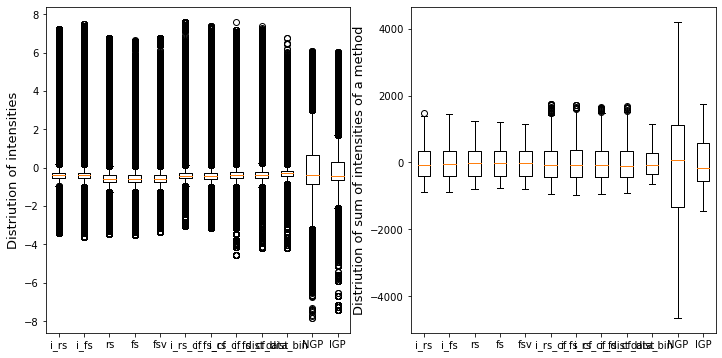

In [39]:
f, (axl, axr) = plt.subplots(1,2, figsize=(12,6))

datas = [ds for ds in treated_datasets.values()]
datas.append(data_NGP)
datas.append(data_IGP)

names = list(treated_datasets.keys())
names.append('NGP')
names.append('IGP')

axl.boxplot([ds.values.flatten() for ds in datas])
axl.set_ylabel('Distriution of intensities', fontsize=13)
axl.set_xticklabels(names)

axr.boxplot([ds.sum(axis=1) for ds in datas])
axr.set_ylabel('Distriution of sum of intensities of a method', fontsize=13)
axr.set_xticklabels(names)

plt.show()

The different characteristics of the imputation is due to the data being imputed after normalization, and hence why it is more similar to real data treated this way.

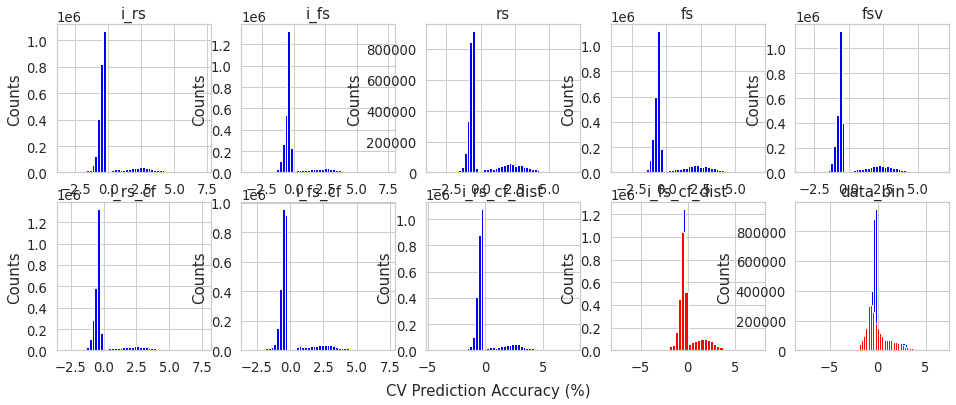

In [40]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axs = plt.subplots(2, 5, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        for ax, data in zip(axs.ravel(), intensity_datasets):
            n_bins = 34
            ax.hist(treated_datasets[data].values.flatten(), bins=50, color='blue')
            ax.set_title(data, fontsize=15)
            ax.set_ylabel('Counts', fontsize=15)
        
        axs[1][4].hist(data_NGP.values.flatten(), bins=75, color='red')
        axs[1][3].hist(data_IGP.values.flatten(), bins=40, color='red')
    f.text(0.5, 0.05, 'CV Prediction Accuracy (%)', ha='center', va='top', fontsize=15)

In [41]:
test = intensity_datasets[data].astype('float').values.flatten()
test[~np.isnan(test)]

array([0.00152536, 0.00166122, 0.00113323, ..., 0.0020561 , 0.00209683,
       0.00123522])

In [42]:
# Read normalized linearly generated data
data_N = pd.read_csv('store_data/generated_data_N.csv')
data_N = data_N.set_index(data_N.columns[0])

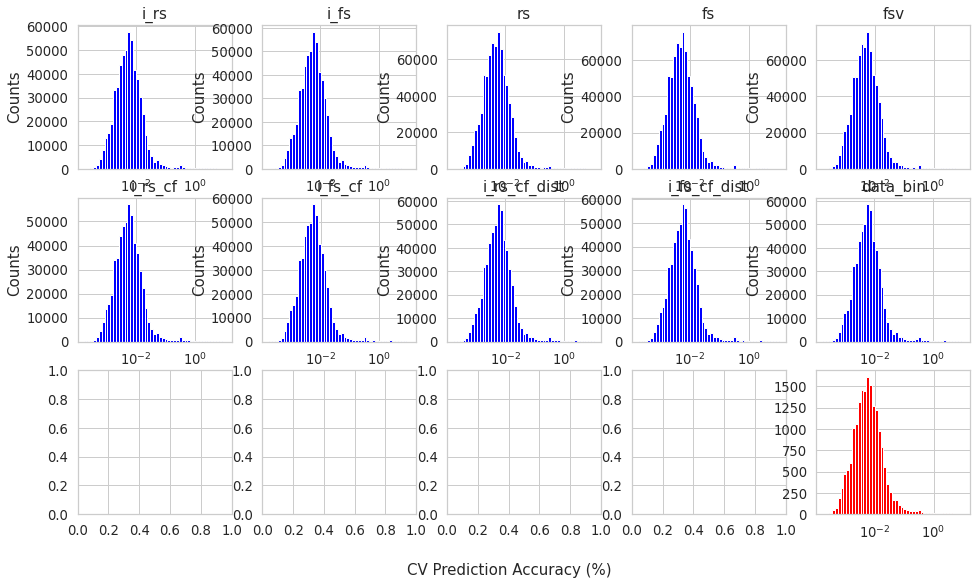

In [43]:
# Setting up an image with the distribution of intensities imputed in the binary datasets and the linearly generated
# data_NGP

# Data represented in logarithmic form
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axs = plt.subplots(3, 5, figsize = (16,9))#, sharey='row')#, sharex='col')
        
        for ax, data in zip(axs.ravel(), intensity_datasets):
            
            test = intensity_datasets[data].astype('float').values.flatten() # All values in the data
            test = test[~np.isnan(test)]
            hist, bins = np.histogram(test, bins=50)
            logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),50)
            ax.hist(test, bins=logbins, color='blue')
            ax.set_title(data, fontsize=15)
            ax.set_ylabel('Counts', fontsize=15)
            ax.set_xscale('log')
        
        test = norm.astype('float').values.flatten()
        test = test[~np.isnan(test)]
        hist, bins = np.histogram(test, bins=50)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),50)
        axs[2][4].hist(norm.values.flatten(), bins=logbins, color='red')
        axs[2][4].set_xscale('log')
    f.text(0.5, 0.05, 'CV Prediction Accuracy (%)', ha='center', va='top', fontsize=15)

In [44]:
set(treated_datasets['i_rs_cf_dist'].loc[:,97.588790])

{-0.3812267011651663,
 1.719743944993966,
 2.3479763584130597,
 2.5607314812562754,
 2.6014015217547666,
 2.6099031500001333,
 2.612262184846248,
 2.6124642722875286,
 2.6284683247463225,
 2.632257443846565,
 2.649301638242179,
 2.6776573094799105,
 2.6923353613472782,
 2.7121524836024387,
 2.7170545316824435,
 2.729152325900778,
 2.736338452845194,
 2.766251455980824,
 2.774237259787338,
 2.7918357649795866,
 2.8411031038677197,
 2.8493463661848333,
 2.8788275352908577,
 2.8907814136589836,
 2.891495310836429,
 2.903605395900733,
 2.9255308484574947,
 2.963991756610876,
 2.965917104759476,
 2.9781846988973206,
 2.987586033351797,
 2.991618974130567,
 2.9992634928580797,
 3.0033670926001768,
 3.0283225850097457,
 3.0302968411685027,
 3.0470990085063843,
 3.0616890968287556,
 3.0722377840981916,
 3.0779851046793554,
 3.0837158050650784,
 3.0841357259923714,
 3.0959361935426655,
 3.1046806470451975,
 3.111819765090779,
 3.123837814428514,
 3.1482499337253036,
 3.1508880588925536,
 3.1888

In [45]:
set(intensity_datasets['i_rs_cf_dist'].loc[:,97.588790])

{nan,
 0.0005870469884342454,
 0.0009498433303367325,
 0.001117953481898224,
 0.0011533267645267627,
 0.001160861436011139,
 0.0011629608699194826,
 0.001163140895029199,
 0.0011774865986315102,
 0.001180908910495881,
 0.0011964265529088582,
 0.0012226956753577888,
 0.0012365194035330704,
 0.0012554313612277695,
 0.0012601539578631514,
 0.0012718850433261204,
 0.0012789049800012939,
 0.0013085449404285014,
 0.0013165733729807757,
 0.0013344401292066709,
 0.0013857584780199352,
 0.0013945356141663908,
 0.001426383548482885,
 0.0014395034081229868,
 0.0014402907465005397,
 0.0014537124423508747,
 0.001478331596158438,
 0.0015225291449954249,
 0.001524776073860019,
 0.0015391707397135325,
 0.001550294074836104,
 0.0015550903158080577,
 0.001564222442942614,
 0.0015691466953587211,
 0.0015994284485541502,
 0.0016018488687972116,
 0.00162259697408615,
 0.0016408313751081476,
 0.0016541424159960487,
 0.0016614401588272202,
 0.0016687488542846958,
 0.0016692856664017274,
 0.00168444178469127,

In [46]:
for i in range(len(intensity_datasets['i_rs_cf_dist'].loc[:,97.588790])):
    if intensity_datasets['i_rs_cf_dist'].loc[:,97.588790].iloc[i] > 0:
        print(i, lbls_bin[i], intensity_datasets['i_rs_cf_dist'].loc[:,97.588790].iloc[i])

0 vinifera 0.0015391707397135325
5 vinifera 0.0012718850433261204
7 vinifera 0.0024689142345344552
11 vinifera 0.0018592206900028005
15 vinifera 0.0022415369251716504
17 vinifera 0.0013085449404285014
18 vinifera 0.0023332616502767466
19 vinifera 0.0023546572744324043
21 vinifera 0.0015225291449954249
27 vinifera 0.0014537124423508747
28 vinifera 0.0012226956753577888
30 vinifera 0.001117953481898224
31 vinifera 0.0017050595961197988
32 vinifera 0.001871157036138724
37 vinifera 0.0025073890806384417
42 vinifera 0.0024570177461771397
46 vinifera 0.002148586525294396
50 vinifera 0.001969682570101857
56 vinifera 0.002350329846163444
62 vinifera 0.0018585984799849198
68 vinifera 0.0019249189521590622
70 vinifera 0.0020600065933202316
73 vinifera 0.001478331596158438
75 vinifera 0.0024207702329748426
76 vinifera 0.001160861436011139
82 vinifera 0.001564222442942614
104 vinifera 0.001811820737415266
114 vinifera 0.0020305641264082184
125 vinifera 0.0014402907465005397
137 vinifera 0.00242561

In [47]:
for i in range(len(intensity_datasets['data_bin'].loc[:,97.588790])):
    if intensity_datasets['data_bin'].loc[:,97.588790].iloc[i] > 0:
        print(i, lbls_bin[i], intensity_datasets['data_bin'].loc[:,97.588790].iloc[i])

0 vinifera 0.0015253621903432756
5 vinifera 0.0014993143353173467
6 vinifera 0.002327809922743564
7 vinifera 0.0020608045067752787
15 vinifera 0.0024180718724053814
17 vinifera 0.002287292568583091
18 vinifera 0.0016229085768154907
19 vinifera 0.002476005916935877
21 vinifera 0.0012928401201646404
27 vinifera 0.0014520918701762264
28 vinifera 0.0012051279593931423
30 vinifera 0.0012090380503194604
31 vinifera 0.0012123865681444653
32 vinifera 0.0013959297385790319
33 vinifera 0.0012670892570583283
42 vinifera 0.0019046101770187867
46 vinifera 0.0018405769075224472
50 vinifera 0.0019435504635266813
62 vinifera 0.002529602672577227
68 vinifera 0.002044231265223127
70 vinifera 0.0024080262479496055
71 vinifera 0.0014124910829226495
73 vinifera 0.002188320801072404
75 vinifera 0.00231900783347616
76 vinifera 0.001844974324049687
82 vinifera 0.0022064940281741876
144 vinifera 0.002250457108276691
154 vinifera 0.0022183128463346296
159 vinifera 0.002335398238115703
187 vinifera 0.00149196879

In [48]:
for i in range(len(datasets['vitis_types']['data'].loc[:,97.588790])):
    if datasets['vitis_types']['data'].loc[:,97.588790].iloc[i] > 0:
        print(i, datasets['vitis_types']['target'][i], datasets['vitis_types']['data'].loc[:,97.588790].iloc[i])

18 vinifera 547566.0
19 vinifera 800618.0
20 vinifera 585964.0


# Comparing Feature occurrence and Intensity imputed data to real data

The binarized and intensity imputed data chosen to be the comparison is the one obtained from the 'i_rs_cf_dist' method, that is random sampling accounting for balance between number of 1s and 0s in the data and by the number of times each feature appears in samples as well as with the 'change factor' activated and set to 2.

From the 1024 generated samples in each case (512 of each class), a total of 50 will be randomly chosen (25 of each class) to compare to the 33 real samples (18 of a class, 15 of another) of the real data.

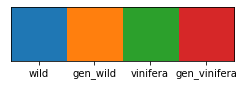

In [49]:
colours2 = sns.color_palette('tab10', 4)[:5]

ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
label_colors_test = {lbl: c for lbl, c in zip(ordered_labels_test, colours2)}

sns.palplot(label_colors_test.values())
new_ticks_test = plt.xticks(range(len(ordered_labels_test)), ordered_labels_test)

## Feature Occurrence Data

In [50]:
results.keys()

dict_keys(['data_bin', 'i_rs', 'i_fs', 'rs', 'fs', 'fsv', 'i_rs_cf', 'i_fs_cf', 'i_rs_cf_dist', 'i_fs_cf_dist'])

In [51]:
# Choosing the 50 samples that will be compared against the real data in some cases
bin_arti_data = results['i_rs_cf_dist'].copy()

rng = np.random.default_rng(7519)
idxs = list(rng.choice(512, size=25, replace=False)) + list(rng.choice(512, size=25, replace=False) + 512)

bin_arti_data = bin_arti_data.iloc[idxs]
bin_arti_data_lbls = ['gen_wild']*(len(bin_arti_data)//2) + ['gen_vinifera']*(len(bin_arti_data)//2)
#arti_data

#### PCA and tSNE plots and dataset characteristics

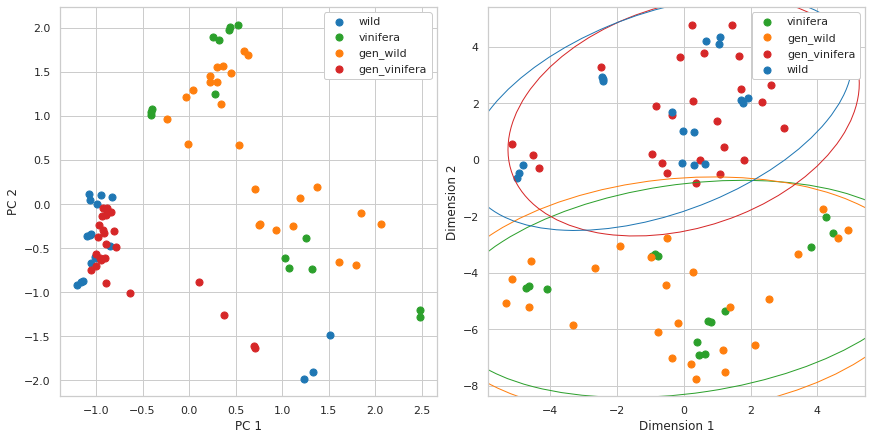

In [52]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl, axr) = plt.subplots(1,2, figsize=(12,6), constrained_layout=True)
        
        dfs_temp = pd.concat((datasets['vitis_types']['BinSim'],
                              bin_arti_data))
        temp_lbls = datasets['vitis_types']['target'].copy()
        temp_lbls.extend(['gen_wild']*(len(bin_arti_data)//2))
        temp_lbls.extend(['gen_vinifera']*(len(bin_arti_data)//2))

        principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                             return_var_ratios=False)

        lcolors = label_colors_test

        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axl)
        #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        dfs_temp = pd.concat((datasets['vitis_types']['BinSim'],
                              bin_arti_data))
        X = dfs_temp.copy()
        X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                          init='random', verbose=0).fit_transform(X)

        df = X_embedded
        labels = temp_lbls
        lcolors = label_colors_test

        plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=axr)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)


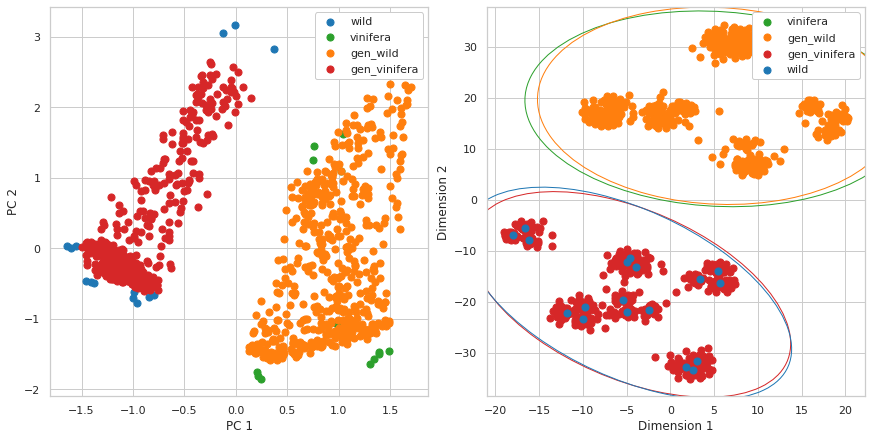

In [53]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl, axr) = plt.subplots(1,2, figsize=(12,6), constrained_layout=True)
        
        dfs_temp = pd.concat((datasets['vitis_types']['BinSim'],
                              results['i_rs_cf_dist']))
        temp_lbls = datasets['vitis_types']['target'].copy()
        temp_lbls.extend(['gen_wild']*(len(results['i_rs_cf_dist'])//2))
        temp_lbls.extend(['gen_vinifera']*(len(results['i_rs_cf_dist'])//2))

        principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                             return_var_ratios=False)

        lcolors = label_colors_test

        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axl)
        #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        dfs_temp = pd.concat((datasets['vitis_types']['BinSim'],
                              results['i_rs_cf_dist']))
        X = dfs_temp.copy()
        X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                          init='random', verbose=0).fit_transform(X)

        df = X_embedded
        labels = temp_lbls
        lcolors = label_colors_test

        plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=axr)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)


Review Dataset Characteristics

In [54]:
tg = lbls_bin
data_characteristics = [characterize_binary_data(ds, name, tg) for name,ds in results.items()]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,average # of features per sample (std),# features per sample ranges,# features per sample median,average # of times feature appear in sample (std),min and max # of times a feature appears in a sample,# classes,samples / class
Dataset,,,,,,,,,
data_bin,1024,3026,551.82 (133.8),(339.0 - 918.0),519.5,186.74 (182.65),41.0 - 1024.0,2,512.0
i_rs,1024,3026,551.52 (134.17),(332.0 - 935.0),517.5,186.64 (160.44),56.0 - 1024.0,2,512.0
i_fs,1024,3026,551.94 (133.81),(339.0 - 918.0),520.0,186.78 (160.48),54.0 - 1024.0,2,512.0
rs,1024,3026,744.17 (108.94),(565.0 - 1045.0),725.0,251.83 (146.54),120.0 - 1024.0,2,512.0
fs,1024,3026,744.53 (107.33),(578.0 - 1053.0),721.0,251.95 (146.46),116.0 - 1024.0,2,512.0
fsv,1024,3026,744.16 (107.07),(574.0 - 1037.0),719.0,251.83 (146.4),124.0 - 1024.0,2,512.0
i_rs_cf,1024,3026,548.08 (141.73),(311.0 - 999.0),526.0,185.47 (148.94),61.0 - 1024.0,2,512.0
i_fs_cf,1024,3026,550.47 (144.4),(305.0 - 996.0),524.0,186.28 (149.37),56.0 - 1024.0,2,512.0
i_rs_cf_dist,1024,3026,553.54 (146.47),(305.0 - 995.0),524.0,187.32 (163.0),49.0 - 1024.0,2,512.0


### Coverage and Density

In [56]:
density_lin_arti, coverage_lin_arti = gem.evaluation_coverage_density_all_k_at_once(
    data_bin, results['i_rs_cf_dist'], metric='jaccard')

print('Linear - Artificial comparison ended.')

density_real_arti, coverage_real_arti = gem.evaluation_coverage_density_all_k_at_once(
   datasets['vitis_types']['BinSim'], results['i_rs_cf_dist'], metric='jaccard')

print('Real - Artificial comparison ended.')

density_real_lin, coverage_real_lin = gem.evaluation_coverage_density_all_k_at_once(
   datasets['vitis_types']['BinSim'], data_bin, metric='jaccard')

print('Real - Linear comparison ended.')

Linear - Artificial comparison ended.
Real - Artificial comparison ended.
Real - Linear comparison ended.


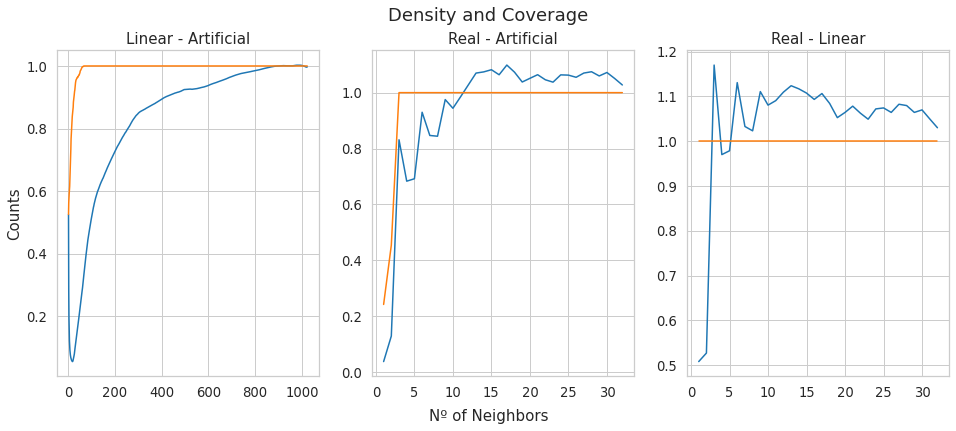

In [57]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        axl.plot(range(1,len(data_bin)), density_lin_arti, label='Density')
        axl.plot(range(1,len(data_bin)), coverage_lin_arti, label='Coverage')
        axl.set_title('Linear - Artificial', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        
        axc.plot(range(1,len(datasets['vitis_types']['BinSim'])), density_real_arti, label='Density')
        axc.plot(range(1,len(datasets['vitis_types']['BinSim'])), coverage_real_arti, label='Coverage')
        axc.set_title('Real - Artificial', fontsize=15)
        
        axr.plot(range(1,len(datasets['vitis_types']['BinSim'])), density_real_lin, label='Density')
        axr.plot(range(1,len(datasets['vitis_types']['BinSim'])), coverage_real_lin, label='Coverage')
        axr.set_title('Real - Linear', fontsize=15)
        
        plt.suptitle('Density and Coverage', fontsize=18)

    f.text(0.5, 0.05, 'Nº of Neighbors', ha='center', va='top', fontsize=15)

### CrossLID (Local Intrinsic Dimensionality) Evaluation

In [58]:
CrossLIDs = {}

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(data_bin, results['i_rs_cf_dist'], metric='jaccard')
CrossLIDs['LinVArti'] = c_lid
print('Linear - Artificial Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['BinSim'], results['i_rs_cf_dist'], 
                                                    metric='jaccard')
CrossLIDs['RealVArti'] = c_lid
print('Real - Artificial Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['BinSim'], data_bin, metric='jaccard')
CrossLIDs['RealVLin'] = c_lid
print('Real - Linear Done')

Linear - Artificial Done
Real - Artificial Done
Real - Linear Done


In [59]:
LIDs = {}

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(results['i_rs_cf_dist'], metric='jaccard')
LIDs['Artificial'] = lid
print('Artificial Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(data_bin, metric='jaccard')
LIDs['Linear'] = lid
print('Linear Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(datasets['vitis_types']['BinSim'], metric='jaccard')
LIDs['Real'] = lid
print('Real Data Done')

C:\Users\franc\Documents\Doutoramento\Data Augmentation\For Repo\gan_evaluation_metrics.py:187: RuntimeWarning: divide by zero encountered in reciprocal
  LID = (rmax - rsum/k)**(-1) # Estimating LID


Artificial Data Done
Linear Data Done
Real Data Done


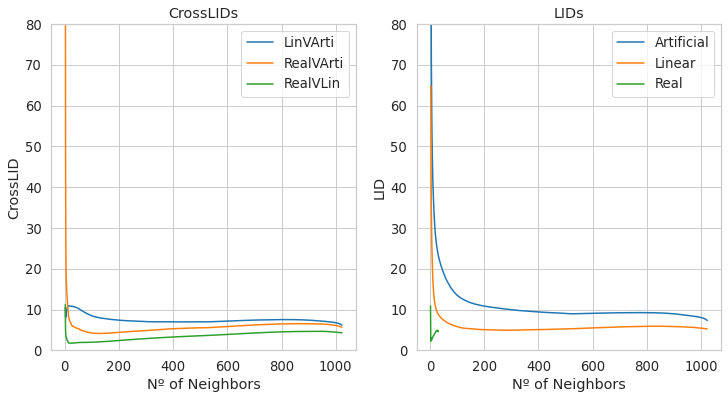

In [60]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(12,6))
        for l, data in CrossLIDs.items():
            axl.plot(range(2,len(data)+2), data, label=l)
            
        axl.set_ylim([0,80])
        axl.legend()
        axl.set(xlabel='Nº of Neighbors', ylabel='CrossLID', title='CrossLIDs')
        
        for l, data in LIDs.items():
            axr.plot(range(2,len(data)+2), data, label=l)
            
        axr.set_ylim([0,80])
        axr.legend()
        axr.set(xlabel='Nº of Neighbors', ylabel='LID', title='LIDs')

### Hierarchical Clustering

In [61]:
# alternative dendogram plots - Newer
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def color_list_to_matrix_and_cmap(colors, ind, axis=0):
        if any(issubclass(type(x), list) for x in colors):
            all_colors = set(itertools.chain(*colors))
            n = len(colors)
            m = len(colors[0])
        else:
            all_colors = set(colors)
            n = 1
            m = len(colors)
            colors = [colors]
        color_to_value = dict((col, i) for i, col in enumerate(all_colors))

        matrix = np.array([color_to_value[c]
                           for color in colors for c in color])

        matrix = matrix.reshape((n, m))
        matrix = matrix[:, ind]
        if axis == 0:
            # row-side:
            matrix = matrix.T

        cmap = mpl.colors.ListedColormap(all_colors)
        return matrix, cmap

def plot_dendogram(Z, leaf_names, label_colors, title='', ax=None, no_labels=False, labelsize=12, **kwargs):
    if ax is None:
        ax = plt.gca()
    hier.dendrogram(Z, labels=leaf_names, leaf_font_size=10, above_threshold_color='0.2', orientation='left',
                    ax=ax, **kwargs)
    #Coloring labels
    #ax.set_ylabel('Distance (AU)')
    ax.set_xlabel('Distance (AU)')
    ax.set_title(title, fontsize = 15)
    
    #ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='y', which='major', labelsize=labelsize, pad=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlbls = ax.get_xmajorticklabels()
    xlbls = ax.get_ymajorticklabels()
    rectimage = []
    for lbl in xlbls:
        col = label_colors[lbl.get_text()]
        lbl.set_color(col)
        #lbl.set_fontweight('bold')
        if no_labels:
            lbl.set_color('w')
        rectimage.append(col)

    cols, cmap = color_list_to_matrix_and_cmap(rectimage, range(len(rectimage)), axis=0)

    axins = inset_axes(ax, width="5%", height="100%",
                   bbox_to_anchor=(1, 0, 1, 1),
                   bbox_transform=ax.transAxes, loc=3, borderpad=0)

    axins.pcolor(cols, cmap=cmap, edgecolors='w', linewidths=1)
    axins.axis('off')

In [62]:
# Hierarchical clustering of the latest predictions and testing data, 
# saving the correct 1st cluster fraction results
dfs_temp = np.concatenate((datasets['vitis_types']['BinSim'].values, bin_arti_data.values))

temp_lbls = list(datasets['vitis_types']['target']) + bin_arti_data_lbls
hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='jaccard', method='ward')

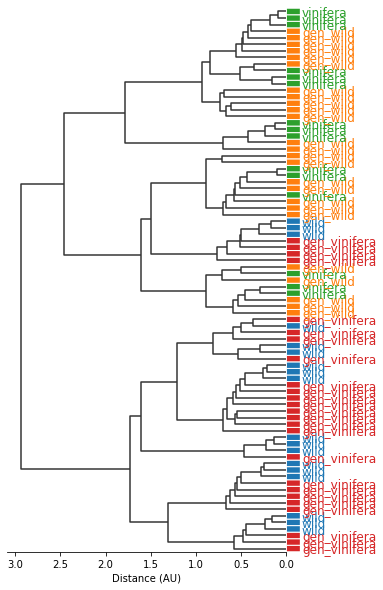

In [63]:
f, ax = plt.subplots(figsize=(5, 10))
gem.plot_dendogram(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)

### Histograms
 
Histograms of Values of normal Real, Generated and GAN Generated Data.

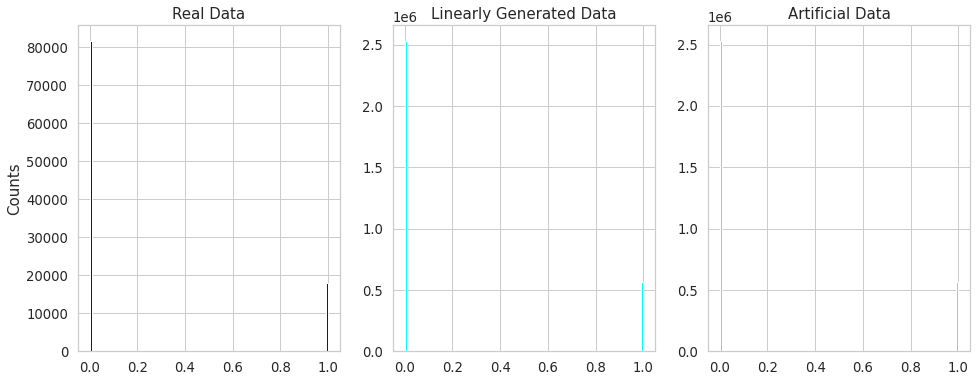

In [64]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        n_bins = 34
        axl.hist(datasets['vitis_types']['BinSim'].values.flatten(), bins=100, color='blue')
        axl.set_title('Real Data', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        axc.hist(data_bin.values.flatten(), bins=100, color='cyan')
        axc.set_title('Linearly Generated Data', fontsize=15)
        
        axr.hist(results['i_rs_cf_dist'].values.flatten(), bins=100, color='skyblue')
        axr.set_title('Artificial Data', fontsize=15)

### Correlations between samples of Real Data and GAN Generated Data

In [65]:
correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['BinSim'], datasets['vitis_types']['BinSim'],
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')
correlation_real_gan = gem.create_sample_correlations(datasets['vitis_types']['BinSim'], results['i_rs_cf_dist'],
                                                   method='pearson')
print('Correlation Real-GAN calculation ended.')
correlation_gan_gan = gem.create_sample_correlations(results['i_rs_cf_dist'], results['i_rs_cf_dist'],
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

Correlation Real-Real calculation ended.
Correlation Real-GAN calculation ended.
Correlation GAN-GAN calculation ended.


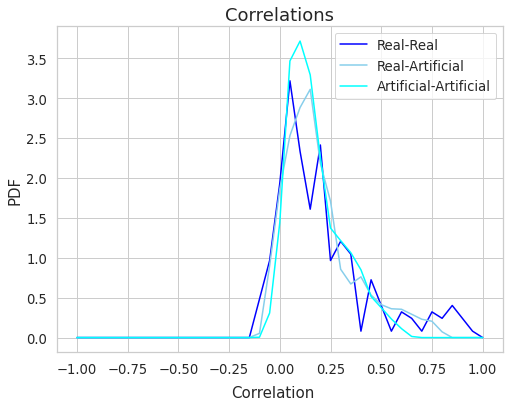

In [66]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (8,6))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real-Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_real_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='skyblue', label='Real-Artificial')
        
        hist = np.histogram(correlation_gan_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='cyan', label='Artificial-Artificial')
        
        ax.legend()
        ax.set_title('Correlations', fontsize=18)

    f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)

### Correlations between features of Real, Generated and GAN Generated Samples

In [ ]:
correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['BinSim'].T, datasets['vitis_types']['BinSim'].T,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_gen_gen = gem.create_sample_correlations(data_bin.T, data_bin.T,
                                                   method='pearson')
print('Correlation Linear-Linear calculation ended.')

correlation_gan_gan = gem.create_sample_correlations(results['i_rs_cf_dist'].T, results['i_rs_cf_dist'].T,
                                                   method='pearson')
print('Correlation Artificial-Artificial calculation ended.')

In [ ]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (8,6))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten()[~np.isnan(correlation_real_real.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real-Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_gen_gen.values.flatten()[~np.isnan(correlation_gen_gen.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='skyblue', label='Real-Artificial')
        
        hist = np.histogram(correlation_gan_gan.values.flatten()[~np.isnan(correlation_gan_gan.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='cyan', label='Artificial-Artificial')
        
        ax.legend()
        ax.set_title('Feature Correlations', fontsize=18)

    f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)

### Counts histograms

In [67]:
results['i_rs_cf_dist'].sum(axis=1)

Arti ('RL', '26')-('RL', '28')_rnd0.2      534.0
Arti ('PN', '24')-('RL', '28')_rnd0.7      492.0
Arti ('RL', '26')-('TRI', '32')_rnd0.4     619.0
Arti ('CS', '30')-('CS', '31')_rnd0.1      701.0
Arti ('PN', '23')-('TRI', '32')_rnd0.7     425.0
                                           ...  
Arti ('SYL', '11')-('SYL', '13')_rnd0.5    476.0
Arti ('SYL', '11')-('SYL', '12')_rnd0.3    489.0
Arti ('CAN', '15')-('SYL', '13')_rnd0.1    459.0
Arti ('CAN', '14')-('LAB', '9')_rnd0.4     380.0
Arti ('LAB', '10')-('ROT', '20')_rnd0.2    434.0
Length: 1024, dtype: float64

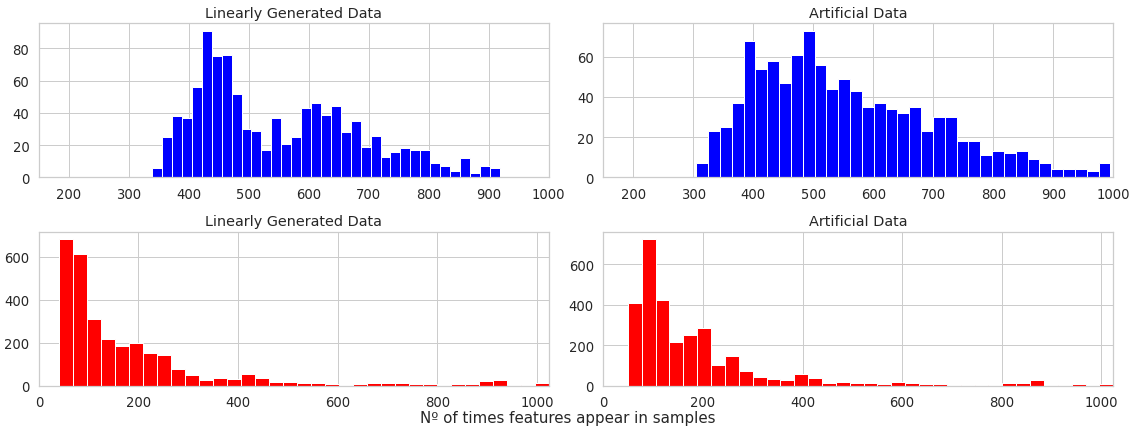

In [68]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axu, axd) = plt.subplots(2, 2, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        axu[0].hist(data_bin.sum(axis=1), bins=35, color='blue')
        axu[0].set_title('Linearly Generated Data')
    
        axu[1].hist(results['i_rs_cf_dist'].sum(axis=1), bins=35, color='blue')
        axu[1].set_title('Artificial Data')
        
        axu[0].set_xlim(150,1000)
        axu[1].set_xlim(150,1000)

    #f.text(0.5, 0.03, 'Nº of features in a sample', ha='center', va='top', fontsize=15)

        axd[0].hist(data_bin.sum(axis=0), bins=35, color='red')
        axd[0].set_title('Linearly Generated Data')
        
        axd[1].hist(results['i_rs_cf_dist'].sum(axis=0), bins=35, color='red')
        axd[1].set_title('Artificial Data')
        
        axd[0].set_xlim(0,1024)
        axd[1].set_xlim(0,1024)
        
        #axs[0][0].set_xlim(0,33)
        plt.tight_layout()

    f.text(0.5, 0.03, 'Nº of times features appear in samples', ha='center', va='top', fontsize=15)

### Profiles of features appearing in vinifera or wild samples

In [69]:
vinifera_counts_artificial = []
wild_counts_artificial = []
for i in results['i_rs_cf_dist'].columns:
    vinifera_counts_artificial.append(results['i_rs_cf_dist'][i].iloc[512:].sum())
    wild_counts_artificial.append(- results['i_rs_cf_dist'][i].iloc[:512].sum())

In [70]:
wild_counts_artificial

[-172.0,
 -106.0,
 -182.0,
 -181.0,
 -119.0,
 -276.0,
 -83.0,
 -114.0,
 -83.0,
 -158.0,
 -76.0,
 -167.0,
 -7.0,
 -118.0,
 -234.0,
 -8.0,
 -64.0,
 -115.0,
 -9.0,
 -103.0,
 -303.0,
 -8.0,
 -5.0,
 -3.0,
 -78.0,
 -79.0,
 -4.0,
 -278.0,
 -4.0,
 -94.0,
 -112.0,
 -6.0,
 -138.0,
 -6.0,
 -128.0,
 -3.0,
 -139.0,
 -507.0,
 -275.0,
 -76.0,
 -87.0,
 -162.0,
 -182.0,
 -169.0,
 -294.0,
 -136.0,
 -359.0,
 -125.0,
 -253.0,
 -122.0,
 -244.0,
 -286.0,
 -77.0,
 -169.0,
 -181.0,
 -270.0,
 -5.0,
 -186.0,
 -257.0,
 -189.0,
 -156.0,
 -154.0,
 -185.0,
 -207.0,
 -3.0,
 -76.0,
 -67.0,
 -361.0,
 -76.0,
 -68.0,
 -5.0,
 -162.0,
 -198.0,
 -164.0,
 -157.0,
 -77.0,
 -262.0,
 -1.0,
 -80.0,
 -5.0,
 -191.0,
 -4.0,
 -7.0,
 -1.0,
 -6.0,
 -5.0,
 -5.0,
 -68.0,
 -169.0,
 -109.0,
 -109.0,
 -94.0,
 -84.0,
 -89.0,
 -71.0,
 -160.0,
 -104.0,
 -58.0,
 -204.0,
 -111.0,
 -197.0,
 -156.0,
 -200.0,
 -7.0,
 -236.0,
 -110.0,
 -81.0,
 -126.0,
 -167.0,
 -179.0,
 -4.0,
 -76.0,
 -201.0,
 -74.0,
 -118.0,
 -384.0,
 -5.0,
 -84.0,
 -5.0,
 -74.0,

In [71]:
vinifera_counts_linear = []
wild_counts_linear = []
for i in data_bin.columns:
    vinifera_counts_linear.append(data_bin[i].iloc[512:].sum())
    wild_counts_linear.append(- data_bin[i].iloc[:512].sum())

In [72]:
wild_counts_linear 

[-182.0,
 -95.0,
 -203.0,
 -207.0,
 -98.0,
 -337.0,
 -83.0,
 -95.0,
 -73.0,
 -134.0,
 -70.0,
 -170.0,
 -0.0,
 -114.0,
 -246.0,
 -0.0,
 -54.0,
 -109.0,
 -0.0,
 -91.0,
 -350.0,
 -0.0,
 -0.0,
 -0.0,
 -64.0,
 -68.0,
 -0.0,
 -321.0,
 -0.0,
 -91.0,
 -106.0,
 -0.0,
 -152.0,
 -0.0,
 -129.0,
 -0.0,
 -136.0,
 -512.0,
 -316.0,
 -67.0,
 -76.0,
 -164.0,
 -199.0,
 -170.0,
 -341.0,
 -114.0,
 -395.0,
 -112.0,
 -309.0,
 -115.0,
 -277.0,
 -340.0,
 -66.0,
 -168.0,
 -205.0,
 -319.0,
 -0.0,
 -204.0,
 -277.0,
 -240.0,
 -161.0,
 -146.0,
 -196.0,
 -211.0,
 -0.0,
 -68.0,
 -62.0,
 -401.0,
 -67.0,
 -63.0,
 -0.0,
 -181.0,
 -213.0,
 -166.0,
 -156.0,
 -63.0,
 -303.0,
 -0.0,
 -60.0,
 -0.0,
 -199.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -59.0,
 -178.0,
 -99.0,
 -98.0,
 -95.0,
 -78.0,
 -75.0,
 -66.0,
 -162.0,
 -100.0,
 -59.0,
 -207.0,
 -99.0,
 -200.0,
 -154.0,
 -217.0,
 -0.0,
 -276.0,
 -103.0,
 -76.0,
 -125.0,
 -170.0,
 -172.0,
 -0.0,
 -69.0,
 -237.0,
 -64.0,
 -103.0,
 -406.0,
 -0.0,
 -66.0,
 -0.0,
 -63.0,
 -62.0

In [73]:
vinifera_counts_real = []
wild_counts_real = []
for i in datasets['vitis_types']['BinSim'].columns:
    subset = datasets['vitis_types']['BinSim'][[i=='vinifera' for i in datasets['vitis_types']['target']]]
    vinifera_counts_real.append(subset[i].sum())
    subset = datasets['vitis_types']['BinSim'][[i=='wild' for i in datasets['vitis_types']['target']]]
    wild_counts_real.append(- subset[i].sum())

Making bar plots representing the number of samples of each class each feature appears in (kinda of a profile of the dataset)

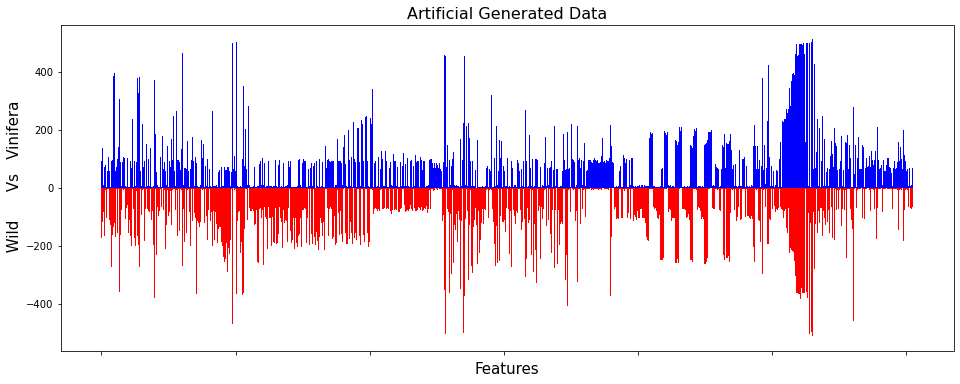

In [74]:
f, ax = plt.subplots(1, 1, figsize=(16, 6))

x = range(len(data_bin.columns))
ax.bar(x, wild_counts_artificial, width=1, color='r')
ax.bar(x, vinifera_counts_artificial, width=1, color='b')
ax.set_xticklabels([])
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('     Wild      Vs   Vinifera', fontsize=15)
ax.set_title('Artificial Generated Data', fontsize=16)

plt.show()

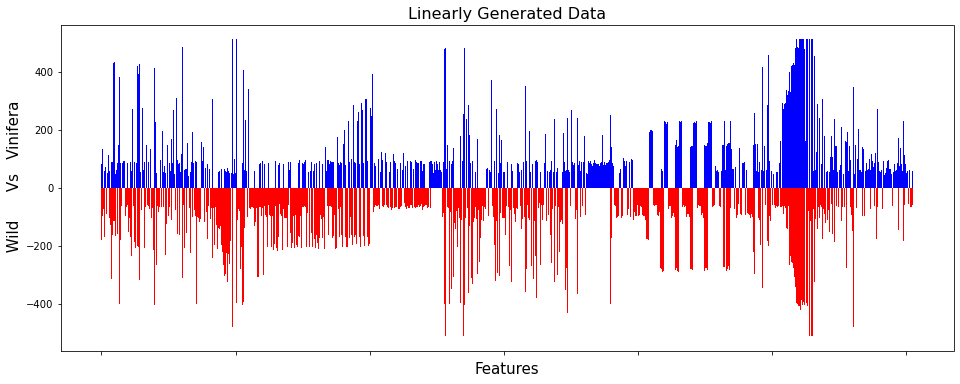

In [75]:
f, ax = plt.subplots(1, 1, figsize=(16, 6))

x = range(len(data_bin.columns))
ax.bar(x, wild_counts_linear, width=1, color='r')
ax.bar(x, vinifera_counts_linear, width=1, color='b')
ax.set_xticklabels([])
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('     Wild      Vs   Vinifera', fontsize=15)
ax.set_title('Linearly Generated Data', fontsize=16)

plt.show()

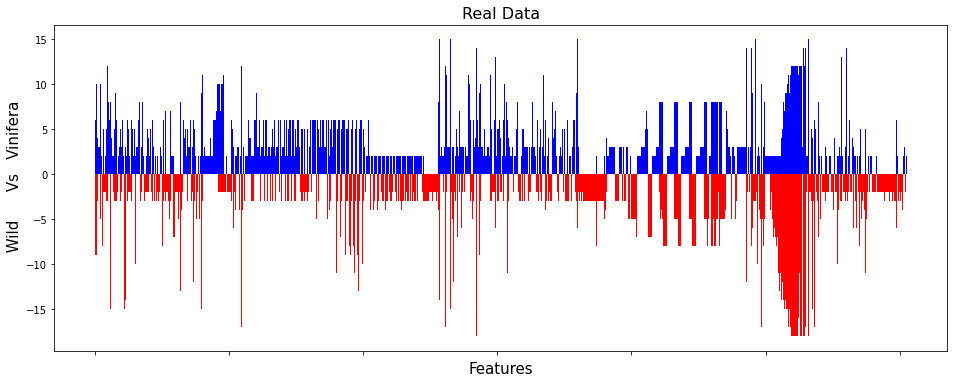

In [76]:
f, ax = plt.subplots(1, 1, figsize=(16, 6))

x = range(len(data_bin.columns))
ax.bar(x, wild_counts_real, width=1, color='r')
ax.bar(x, vinifera_counts_real, width=1, color='b')
ax.set_xticklabels([])
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('     Wild      Vs   Vinifera', fontsize=15)
ax.set_title('Real Data', fontsize=16)

plt.show()

### CAS (Classification Accuracy Score)

In [77]:
bin_arti_data_labels = [0]*(len(bin_arti_data)//2) + [1]*(len(bin_arti_data)//2)
t_data = datasets['vitis_types']['BinSim'].copy()
t_labels = pd.get_dummies(datasets['vitis_types']['target']).values[:,0]

lbls_bin_n = [0]*(len(lbls_bin)//2) + [1]*(len(lbls_bin)//2)

Random Forest Tests

In [78]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
top_tree_in_grid=300

# Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,top_tree_in_grid,5)}

rf = skensemble.RandomForestClassifier(n_estimators=100)
clf = GridSearchCV(rf, values, cv=5)

clf.fit(bin_arti_data, bin_arti_data_labels)
param = clf.cv_results_['param_n_estimators']
test_score = clf.cv_results_['mean_test_score']

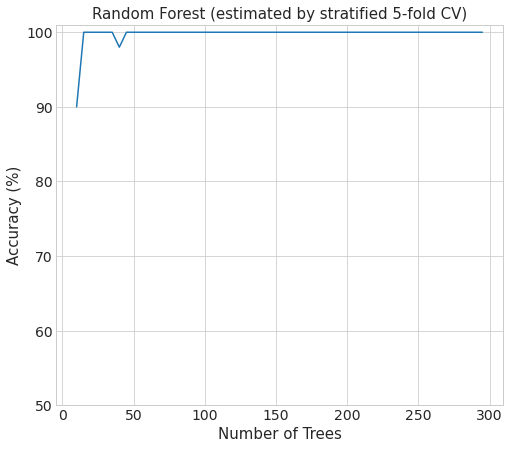

In [79]:
# Plotting the results and adjusting parameters of the plot
with plt.style.context('seaborn-whitegrid'):
    f, ax = plt.subplots(figsize=(8,7))

    plt.plot(param, test_score*100)

    plt.ylabel('Accuracy (%)', fontsize = 15)
    plt.xlabel('Number of Trees', fontsize = 15)
    plt.ylim(50,101)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Random Forest (estimated by stratified 5-fold CV)', fontsize=15)

In [80]:
rf_mod = ma.RF_model(results['i_rs_cf_dist'], lbls_bin_n, return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)
print(rf_mod['cv_scores'])

{'fit_time': array([0.57082272, 0.585536  , 0.57553959, 0.48146081, 0.47396064]), 'score_time': array([0.04684639, 0.04385281, 0.041821  , 0.03124547, 0.03127623]), 'test_score': array([1., 1., 1., 1., 1.])}


In [81]:
rf_mod['model'].score(t_data, t_labels)

0.0

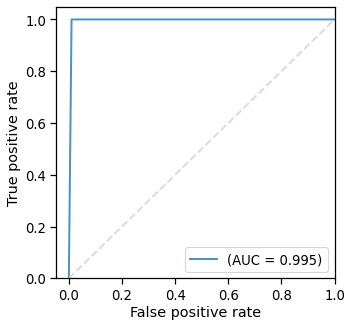

In [82]:
res = ma.RF_ROC_cv(treated_datasets['i_rs_cf_dist'], lbls_bin_n, 1, n_fold=5, n_trees=200, n_iter=50)

with sns.plotting_context("notebook", font_scale=1.2):
    f, ax = plt.subplots(1, 1, figsize=(5,5))
    mean_fpr = res['average fpr']
    mean_tpr = res['average tpr']
    mean_auc = res['mean AUC']
    ax.plot(mean_fpr, mean_tpr,
           label=f'(AUC = {mean_auc:.3f})',
           lw=2, alpha=0.8)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
    ax.legend()
    ax.set_xlim(None,1)
    ax.set_ylim(0,None)
    ax.set(xlabel='False positive rate', ylabel='True positive rate', title='')
          # title="Random forest ROC curves for Vitis types data set")
    plt.show()

PLS-DA Tests

In [83]:
optim_pls = ma.optim_PLSDA_n_components(bin_arti_data, bin_arti_data_labels, encode2as1vector=True, 
                                        max_comp=20, n_fold=5).CVscores

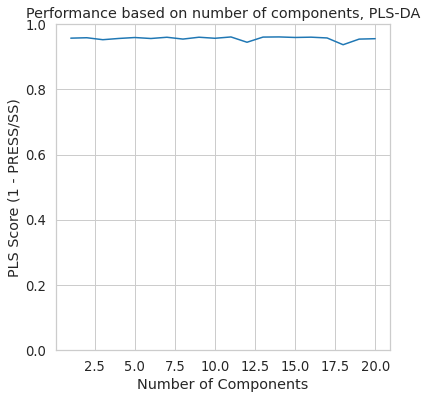

In [84]:
# Plotting the results and adjusting plot parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (6,6))
        
        ax.plot(range(1, len(optim_pls) + 1), optim_pls)
        ax.set(xlabel='Number of Components',
                ylabel='PLS Score (1 - PRESS/SS)',
                title='Performance based on number of components, PLS-DA')
        ax.set_ylim([0, 1])

In [85]:
cv_plsda_model = ma.PLSDA_model_CV(results['i_rs_cf_dist'], lbls_bin_n, n_comp=4,
                   n_fold=5, iter_num=20,
                   encode2as1vector=True, feat_type='Coef')

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [86]:
print(np.mean(cv_plsda_model['accuracy']))

1.0


**This gives 0 accuracy, thus, discrimination is happenning perfectly but backwards.**

In [87]:
plsda = ma.fit_PLSDA_model(results['i_rs_cf_dist'], lbls_bin_n, n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the test group
y_pred = plsda.predict(t_data)
print(y_pred)

# Decision rule for classification
# Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
# In case of 1,0 encoding for two groups, round to nearest integer to compare
nright = 0
rounded = np.round(y_pred)
for i in range(len(y_pred)):
    if rounded[i] == t_labels[i]:
        nright += 1  # Correct prediction


# Calculate accuracy for this iteration
accuracy = (nright / len(t_labels))
print(accuracy)

[[-0.11490649]
 [-0.03827146]
 [-0.0084195 ]
 [ 0.98172318]
 [ 1.03324949]
 [ 1.02939976]
 [-0.0371225 ]
 [-0.0612509 ]
 [-0.06564937]
 [ 0.9825351 ]
 [ 0.99123104]
 [ 1.0028316 ]
 [ 1.03823449]
 [ 0.96096728]
 [ 0.94722171]
 [-0.02367573]
 [-0.02402904]
 [-0.02533196]
 [ 1.06989626]
 [ 1.01605384]
 [ 1.06304656]
 [-0.07429889]
 [-0.02698401]
 [-0.04545192]
 [-0.0679701 ]
 [ 0.07468276]
 [-0.06096314]
 [-0.03706142]
 [-0.09296212]
 [-0.08507996]
 [ 0.96976114]
 [ 0.92780996]
 [ 1.0470882 ]]
1.0


In [88]:
t_labels

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=uint8)

In [89]:
t_labels_2 = []
for i in t_labels:
    if i==1:
        t_labels_2.append('vinifera')
    else:
        t_labels_2.append('wild')

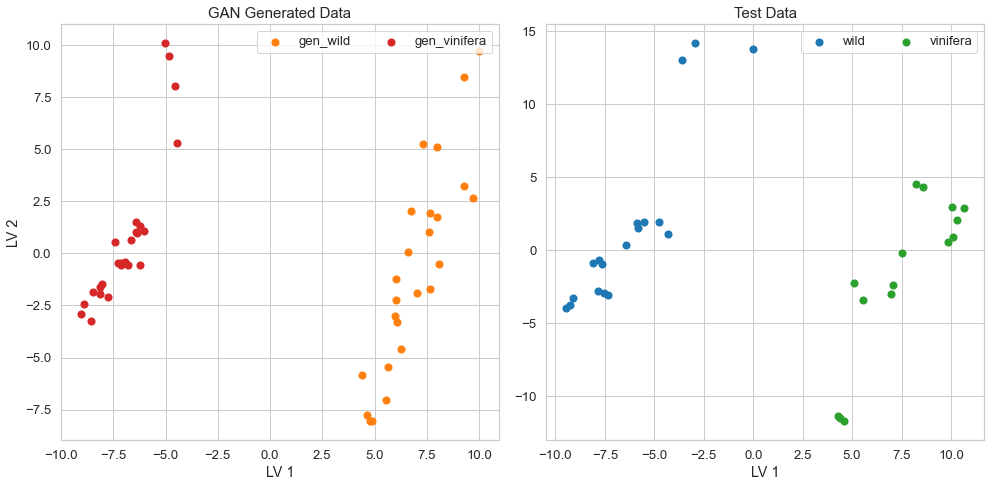

In [90]:
n_components = 4

#t_labels_2 = ['vinifera' for i in true_labels[-3*batch_size:] if i==0 else 'wild']


model, scores = ma.fit_PLSDA_model(bin_arti_data, bin_arti_data_lbls, n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(t_data, t_labels_2, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="GAN Generated Data", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        gem.plot_PLS(scores2, lcolors, title="Test Data", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=2)       
        axl.legend(loc='upper right', ncol=2)       
        plt.tight_layout()
        plt.show()

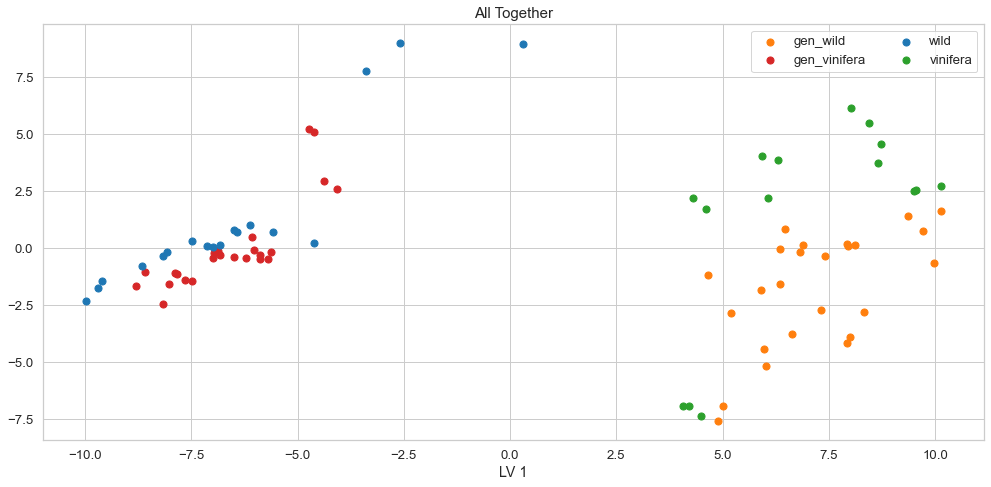

In [91]:
n_components = 4

df_temp = pd.concat([bin_arti_data, t_data])
labels_temp = bin_arti_data_lbls + t_labels_2

model, scores = ma.fit_PLSDA_model(df_temp, labels_temp, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="All Together", ax=ax)

        ax.set_ylabel('')
        ax.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

### Sample Correlation Matrix

Between samples of the real data and a set of generated artificial samples of GANs

In [92]:
# Real Data, organize it to have first all samples of a class, then all samples of the other class
df = datasets['vitis_types']['BinSim'].copy()

samp = df.index
tg = datasets['vitis_types']['target'].copy()
new_order = [x for _, x in sorted(zip(tg, samp))]
new_tg = [x for x, _ in sorted(zip(tg, samp))]

df = df.loc[new_order]
#df

In [93]:
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=results['i_rs_cf_dist'].index, columns=df.index).astype('float')

for i in df.index:
    for j in results['i_rs_cf_dist'].index:
        correlations.loc[j,i] = stats.spearmanr(df.loc[i],
                                               results['i_rs_cf_dist'].loc[j])[0]
        
correlations.columns = new_tg
correlations.index = ['wild_gen']*(len(results['i_rs_cf_dist'])//2) + ['vinifera_gen']*(len(results['i_rs_cf_dist'])//2)

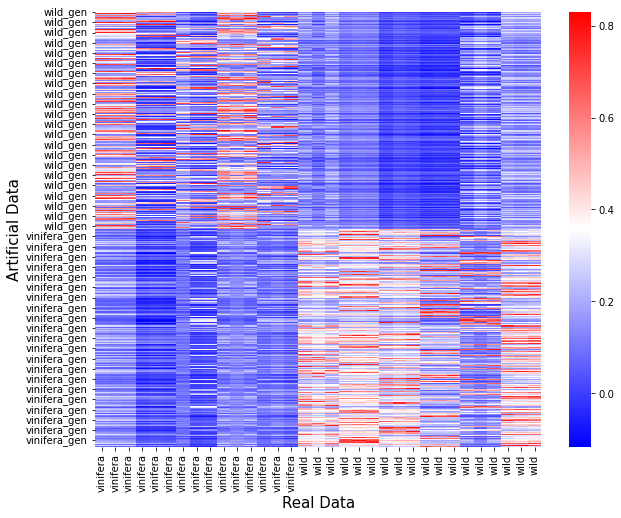

In [94]:
# Draw the heatmap
f, ax = plt.subplots(figsize=(10,8))

g = sns.heatmap(correlations, cmap='bwr')
ax.set_ylabel('Artificial Data', fontsize=15)
ax.set_xlabel('Real Data', fontsize=15)

plt.show()

C:\Users\franc\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


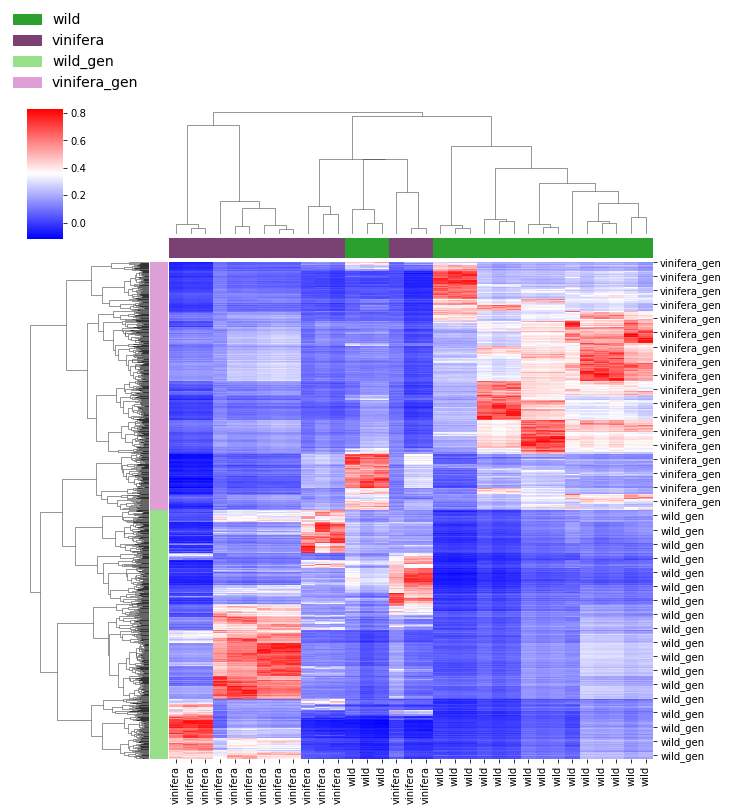

In [95]:
# Draw the heatmap
#f, ax = plt.subplots(figsize=(10,8))
import matplotlib.patches as mpatches

row_cols = [label_colors[lbl] for lbl in new_tg]
row_cols2 = [label_colors[lbl] for lbl in correlations.index]
g = sns.clustermap(correlations, col_colors=row_cols, cmap='bwr', row_colors= row_cols2)
# some tweaks
patches = []
for lbl in ('wild', 'vinifera', 'wild_gen', 'vinifera_gen'):
    patches.append(mpatches.Patch(color=label_colors[lbl], label=lbl))
leg = plt.legend(handles=patches, loc=3, bbox_to_anchor=(-0.75, 1.05, 0.5, 1),
                     frameon=False, fontsize=14) 
#g.ylabel('Artificial Data', fontsize=15)
#g.set_xlabel('Real Data', fontsize=15)

plt.show()

## Intensity imputed data

In [96]:
# Choosing the 50 samples that will be compared against the real data
arti_data = treated_datasets['i_rs_cf_dist'].copy()

rng = np.random.default_rng(7519)
idxs = list(rng.choice(512, size=25, replace=False)) + list(rng.choice(512, size=25, replace=False) + 512)

arti_data = arti_data.iloc[idxs]
arti_data_lbls = ['gen_wild']*(len(arti_data)//2) + ['gen_vinifera']*(len(arti_data)//2)
#arti_data

#### PCA and tSNE plots and dataset characteristics

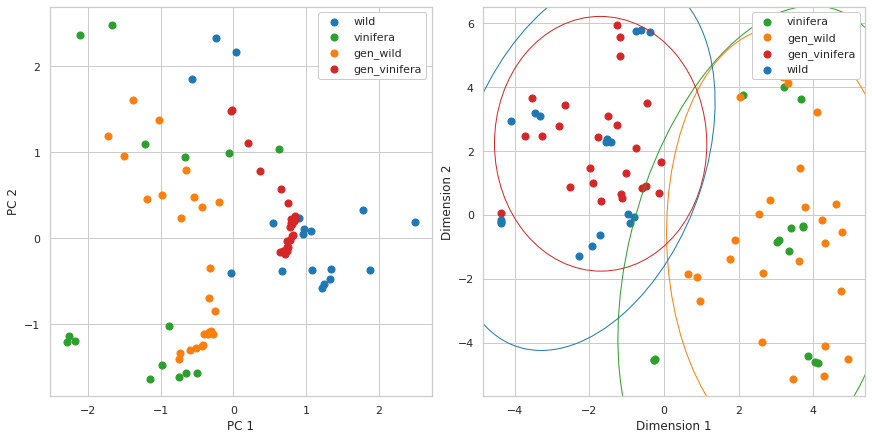

In [97]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl, axr) = plt.subplots(1,2, figsize=(12,6), constrained_layout=True)
        
        dfs_temp = pd.concat((datasets['vitis_types']['NGP'],
                              arti_data))
        temp_lbls = datasets['vitis_types']['target'].copy()
        temp_lbls.extend(['gen_wild']*(len(arti_data)//2))
        temp_lbls.extend(['gen_vinifera']*(len(arti_data)//2))

        principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                             return_var_ratios=False)

        lcolors = label_colors_test

        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axl)
        #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        dfs_temp = pd.concat((datasets['vitis_types']['NGP'],
                              arti_data))
        X = dfs_temp.copy()
        X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                          init='random', verbose=0).fit_transform(X)

        df = X_embedded
        labels = temp_lbls
        lcolors = label_colors_test

        plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=axr)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)


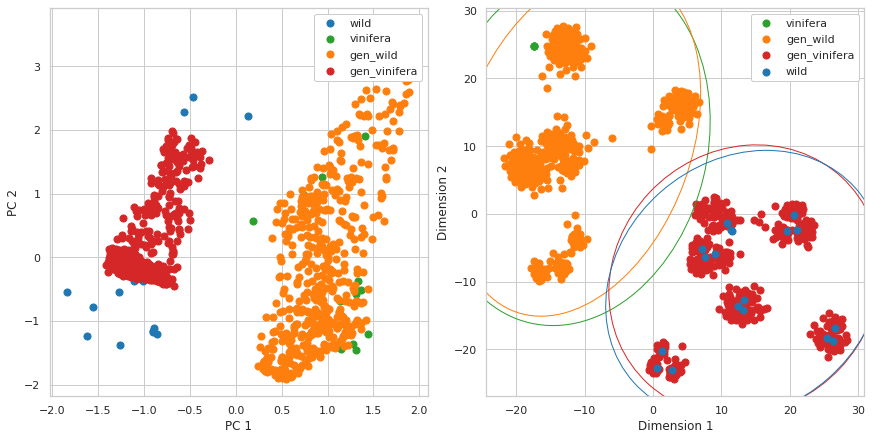

In [98]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl, axr) = plt.subplots(1,2, figsize=(12,6), constrained_layout=True)
        
        dfs_temp = pd.concat((datasets['vitis_types']['NGP'],
                              treated_datasets['i_rs_cf_dist']))
        temp_lbls = datasets['vitis_types']['target'].copy()
        temp_lbls.extend(['gen_wild']*(len(treated_datasets['i_rs_cf_dist'])//2))
        temp_lbls.extend(['gen_vinifera']*(len(treated_datasets['i_rs_cf_dist'])//2))

        principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                             return_var_ratios=False)

        lcolors = label_colors_test

        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axl)
        #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        dfs_temp = pd.concat((datasets['vitis_types']['NGP'],
                              treated_datasets['i_rs_cf_dist']))
        X = dfs_temp.copy()
        X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                          init='random', verbose=0).fit_transform(X)

        df = X_embedded
        labels = temp_lbls
        lcolors = label_colors_test

        plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=axr)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)


In [99]:
names = ['Real data', ' Generated data', 'Arti data']
data_repo = [datasets['vitis_types']['NGP'],
             data_NGP, arti_data]
tgs = [datasets['vitis_types']['target'], lbls_bin, arti_data_lbls]
data_characteristics = [gem.characterize_data(ds, name, tg) for ds,name,tg in zip(data_repo, names, tgs)]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,feature value average (std),feature value ranges,feature value median,# classes,samples / class
Dataset,,,,,,,
Real data,33,3025,-1.6171831661877763e-16 (1.2858020130866499),(-7.114287147421982 - 7.310759295422216),-0.360218,2,16.5
Generated data,1024,3025,-2.328890065184567e-15 (1.2681029630437897),(-7.845091256924552 - 6.096765453559396),-0.360535,2,512.0
Arti data,50,3025,-0.0059713860585469646 (1.2017871613330138),(-4.14298490856848 - 7.08090330820333),-0.385314,2,25.0


In [100]:
data_IGP.pop('554.26202')
treated_datasets['IGP'] = data_IGP
intensities_df = pd.DataFrame(columns=treated_datasets.keys())
sum_intensities_df = pd.DataFrame(columns=treated_datasets.keys())

for i in treated_datasets:
    intensities_df.loc[:, i] = treated_datasets[i].values.flatten() # Intensities
    sum_intensities_df.loc[:, i] = treated_datasets[i].sum(axis=1)
    
#intensities_df

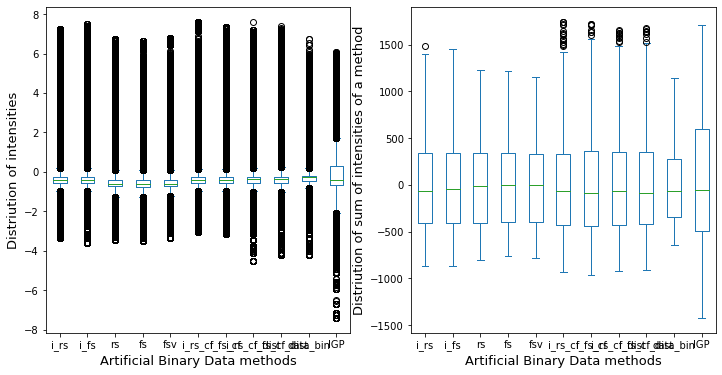

In [101]:
f, (axl, axr) = plt.subplots(1,2, figsize=(12,6))

intensities_df.plot.box(ax=axl)
axl.set_xlabel('Artificial Binary Data methods', fontsize=13)
axl.set_ylabel('Distriution of intensities', fontsize=13)

sum_intensities_df.plot.box(ax=axr)
axr.set_xlabel('Artificial Binary Data methods', fontsize=13)
axr.set_ylabel('Distriution of sum of intensities of a method', fontsize=13)

intensities_df = []
sum_intensities_df = []

#### Hierarchical Clustering

In [102]:
# alternative dendogram plots - Newer
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def color_list_to_matrix_and_cmap(colors, ind, axis=0):
        if any(issubclass(type(x), list) for x in colors):
            all_colors = set(itertools.chain(*colors))
            n = len(colors)
            m = len(colors[0])
        else:
            all_colors = set(colors)
            n = 1
            m = len(colors)
            colors = [colors]
        color_to_value = dict((col, i) for i, col in enumerate(all_colors))

        matrix = np.array([color_to_value[c]
                           for color in colors for c in color])

        matrix = matrix.reshape((n, m))
        matrix = matrix[:, ind]
        if axis == 0:
            # row-side:
            matrix = matrix.T

        cmap = mpl.colors.ListedColormap(all_colors)
        return matrix, cmap

def plot_dendogram2(Z, leaf_names, label_colors, title='', ax=None, no_labels=False, labelsize=12, **kwargs):
    if ax is None:
        ax = plt.gca()
    hier.dendrogram(Z, labels=leaf_names, leaf_font_size=10, above_threshold_color='0.2', orientation='left',
                    ax=ax, **kwargs)
    #Coloring labels
    #ax.set_ylabel('Distance (AU)')
    ax.set_xlabel('Distance (AU)')
    ax.set_title(title, fontsize = 15)
    
    #ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='y', which='major', labelsize=labelsize, pad=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlbls = ax.get_xmajorticklabels()
    xlbls = ax.get_ymajorticklabels()
    rectimage = []
    for lbl in xlbls:
        col = label_colors[lbl.get_text()]
        lbl.set_color(col)
        #lbl.set_fontweight('bold')
        if no_labels:
            lbl.set_color('w')
        rectimage.append(col)

    cols, cmap = color_list_to_matrix_and_cmap(rectimage, range(len(rectimage)), axis=0)

    axins = inset_axes(ax, width="5%", height="100%",
                   bbox_to_anchor=(1, 0, 1, 1),
                   bbox_transform=ax.transAxes, loc=3, borderpad=0)

    axins.pcolor(cols, cmap=cmap, edgecolors='w', linewidths=1)
    axins.axis('off')

In [103]:
# Hierarchical clustering of the latest predictions and testing data, 
# saving the correct 1st cluster fraction results
dfs_temp = np.concatenate((datasets['vitis_types']['NGP'].values, arti_data.values))

temp_lbls = list(datasets['vitis_types']['target']) + arti_data_lbls
hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='euclidean', method='ward')

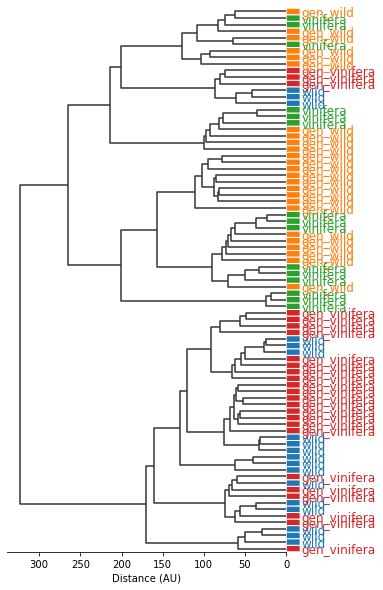

In [104]:
f, ax = plt.subplots(figsize=(5, 10))
plot_dendogram2(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)

#### Density and Coverage between artificial data and linearly generated data ann real data

In [105]:
density_lin_arti, coverage_lin_arti = gem.evaluation_coverage_density_all_k_at_once(
    data_NGP, treated_datasets['i_rs_cf_dist'], metric='Euclidean')

print('Linear - Artificial comparison ended.')

density_real_arti, coverage_real_arti = gem.evaluation_coverage_density_all_k_at_once(
   datasets['vitis_types']['NGP'], treated_datasets['i_rs_cf_dist'], metric='Euclidean')

print('Real - Artificial comparison ended.')

density_real_lin, coverage_real_lin = gem.evaluation_coverage_density_all_k_at_once(
   datasets['vitis_types']['NGP'], data_NGP, metric='Euclidean')

print('Real - Linear comparison ended.')

Linear - Artificial comparison ended.
Real - Artificial comparison ended.
Real - Linear comparison ended.


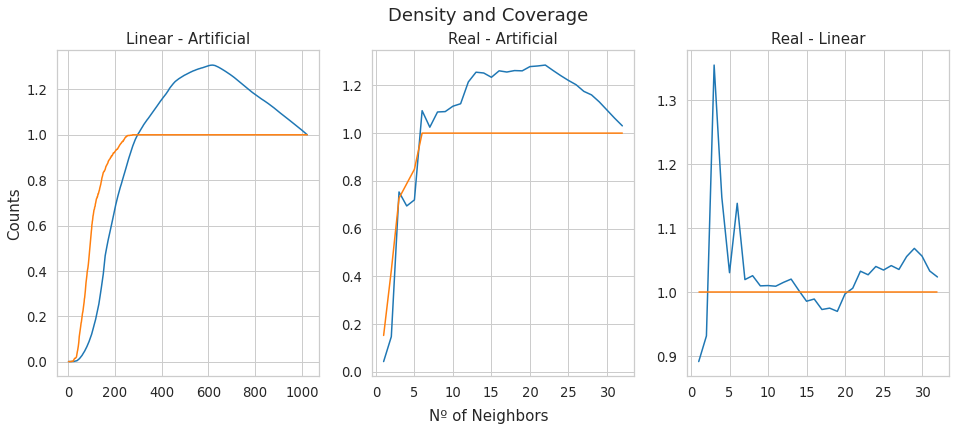

In [106]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        axl.plot(range(1,len(data_NGP)), density_lin_arti, label='Density')
        axl.plot(range(1,len(data_NGP)), coverage_lin_arti, label='Coverage')
        axl.set_title('Linear - Artificial', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        
        axc.plot(range(1,len(datasets['vitis_types']['NGP'])), density_real_arti, label='Density')
        axc.plot(range(1,len(datasets['vitis_types']['NGP'])), coverage_real_arti, label='Coverage')
        axc.set_title('Real - Artificial', fontsize=15)
        
        axr.plot(range(1,len(datasets['vitis_types']['NGP'])), density_real_lin, label='Density')
        axr.plot(range(1,len(datasets['vitis_types']['NGP'])), coverage_real_lin, label='Coverage')
        axr.set_title('Real - Linear', fontsize=15)
        
        plt.suptitle('Density and Coverage', fontsize=18)

    f.text(0.5, 0.05, 'Nº of Neighbors', ha='center', va='top', fontsize=15)

### CrossLID (Local Intrinsic Dimensionality) Evaluation

In [107]:
CrossLIDs = {}

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(data_NGP, treated_datasets['i_rs_cf_dist'], metric='euclidean')
CrossLIDs['LinVArti'] = c_lid
print('Linear - Artificial Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['NGP'], treated_datasets['i_rs_cf_dist'], 
                                                metric='euclidean')
CrossLIDs['RealVArti'] = c_lid
print('Real - Artificial Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['NGP'], data_NGP, metric='euclidean')
CrossLIDs['RealVLin'] = c_lid
print('Real - Linear Done')

Linear - Artificial Done
Real - Artificial Done
Real - Linear Done


In [108]:
LIDs = {}

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(treated_datasets['i_rs_cf_dist'], metric='euclidean')
LIDs['Artificial'] = lid
print('Artificial Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(data_NGP, metric='euclidean')
LIDs['Linear'] = lid
print('Test Set Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(datasets['vitis_types']['NGP'], metric='euclidean')
LIDs['Real'] = lid
print('Real Data Done')

Artificial Data Done
Test Set Done
Real Data Done


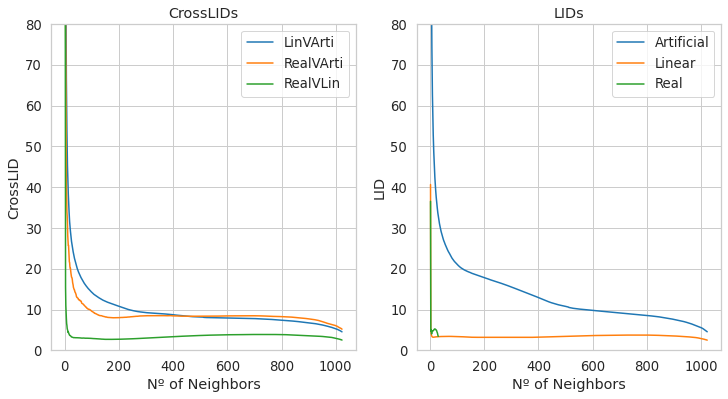

In [109]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(12,6))
        for l, data in CrossLIDs.items():
            axl.plot(range(2,len(data)+2), data, label=l)
            
        axl.set_ylim([0,80])
        axl.legend()
        axl.set(xlabel='Nº of Neighbors', ylabel='CrossLID', title='CrossLIDs')
        
        for l, data in LIDs.items():
            axr.plot(range(2,len(data)+2), data, label=l)
            
        axr.set_ylim([0,80])
        axr.legend()
        axr.set(xlabel='Nº of Neighbors', ylabel='LID', title='LIDs')

### Histograms
 
Histograms of Values of normal Real, Generated and GAN Generated Data.

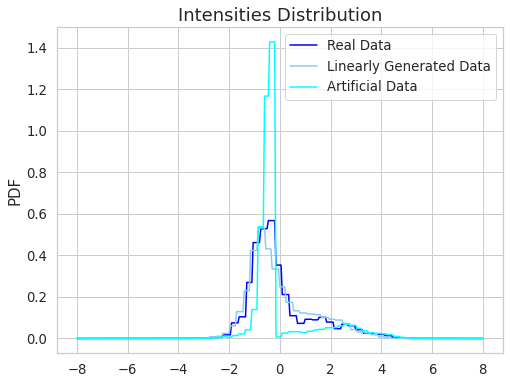

In [110]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (8,6))#, sharey='row')#, sharex='col')
        X = np.arange(-8, 8.01, 0.05)
        hist = np.histogram(datasets['vitis_types']['NGP'].values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real Data')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(data_NGP.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='skyblue', label='Linearly Generated Data')
        
        hist = np.histogram(treated_datasets['i_rs_cf_dist'].values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='cyan', label='Artificial Data')
        
        ax.legend()
        ax.set_title('Intensities Distribution', fontsize=18)

### Correlations between samples of Real Data and GAN Generated Data

In [111]:
correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['NGP'], datasets['vitis_types']['NGP'],
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')
correlation_real_gan = gem.create_sample_correlations(datasets['vitis_types']['NGP'], treated_datasets['i_rs_cf_dist'],
                                                   method='pearson')
print('Correlation Real-GAN calculation ended.')
correlation_gan_gan = gem.create_sample_correlations(treated_datasets['i_rs_cf_dist'], treated_datasets['i_rs_cf_dist'],
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

Correlation Real-Real calculation ended.
Correlation Real-GAN calculation ended.
Correlation GAN-GAN calculation ended.


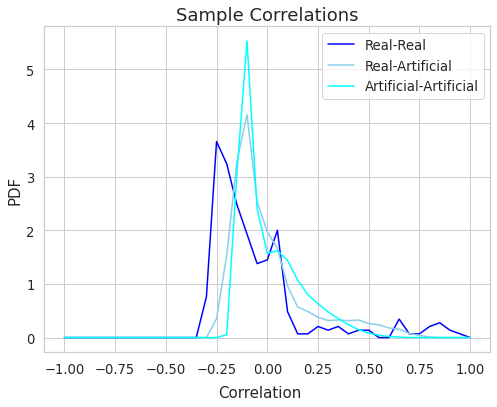

In [112]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axl = plt.subplots(1, 1, figsize = (8,6))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        axl.plot(X, hist_dist.pdf(X), color='blue', label='Real-Real')
        axl.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_real_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        axl.plot(X, hist_dist.pdf(X), color='skyblue', label='Real-Artificial')
        
        hist = np.histogram(correlation_gan_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        axl.plot(X, hist_dist.pdf(X), color='cyan', label='Artificial-Artificial')
        
        axl.legend()
        axl.set_title('Sample Correlations', fontsize=18)

    f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)

### Correlations between features of Real, Generated and GAN Generated Samples

In [ ]:
correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['NGP'].T, datasets['vitis_types']['NGP'].T,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_gen_gen = gem.create_sample_correlations(data_NGP.T, data_NGP.T,
                                                   method='pearson')
print('Correlation Generated-Generated calculation ended.')

correlation_gan_gan = gem.create_sample_correlations(arti_data.T, arti_data.T,
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

In [ ]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (8,6))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten()[~np.isnan(correlation_real_real.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real-Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_gen_gen.values.flatten()[~np.isnan(correlation_gen_gen.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='skyblue', label='Real-Artificial')
        
        hist = np.histogram(correlation_gan_gan.values.flatten()[~np.isnan(correlation_gan_gan.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='cyan', label='Artificial-Artificial')
        
        ax.legend()
        ax.set_title('Feature Correlations', fontsize=18)

    f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)

### CAS (Classification Accuracy Score)

In [113]:
treated_datasets['i_rs_cf_dist']

,97.588680,97.588790,97.588890,97.589990,97.590205,97.591880,98.348930,98.350780,98.351215,98.352190,...,965.863830,965.921180,965.989930,966.003140,966.006120,966.054730,966.057615,966.144500,966.244942,977.114775
"Arti ('RL', '26')-('RL', '28')_rnd0.2",-0.705266,2.978185,-1.288010,-0.666815,-0.830899,1.858155,-0.305559,-0.458673,-0.345597,-0.692124,...,-0.292427,-0.284278,-0.382703,-0.299773,3.907676,-0.322416,-0.220323,-0.310292,-0.36327,-0.268922
"Arti ('PN', '24')-('RL', '28')_rnd0.7",-0.705266,-0.381227,-1.288010,-0.666815,-0.830899,-1.366596,-0.305559,-0.458673,-0.345597,2.136951,...,-0.292427,-0.284278,-0.382703,-0.299773,-0.331485,-0.322416,-0.220323,-0.310292,-0.36327,-0.268922
"Arti ('RL', '26')-('TRI', '32')_rnd0.4",-0.705266,-0.381227,-1.288010,2.043570,-0.830899,1.790661,-0.305559,3.253454,-0.345597,-0.692124,...,-0.292427,-0.284278,-0.382703,-0.299773,3.743979,-0.322416,-0.220323,-0.310292,-0.36327,-0.268922
"Arti ('CS', '30')-('CS', '31')_rnd0.1",-0.705266,-0.381227,2.474432,-0.666815,2.641502,-1.366596,-0.305559,-0.458673,-0.345597,1.640437,...,-0.292427,3.160523,-0.382703,-0.299773,-0.331485,-0.322416,-0.220323,-0.310292,-0.36327,-0.268922
"Arti ('PN', '23')-('TRI', '32')_rnd0.7",2.712428,-0.381227,2.299918,1.787977,-0.830899,1.846777,-0.305559,-0.458673,-0.345597,-0.692124,...,-0.292427,-0.284278,-0.382703,-0.299773,-0.331485,-0.322416,-0.220323,-0.310292,-0.36327,-0.268922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('SYL', '11')-('SYL', '13')_rnd0.5",-0.705266,-0.381227,2.441371,1.337992,2.788075,-1.366596,-0.305559,-0.458673,-0.345597,-0.692124,...,-0.292427,-0.284278,-0.382703,-0.299773,-0.331485,-0.322416,-0.220323,-0.310292,-0.36327,-0.268922
"Arti ('SYL', '11')-('SYL', '12')_rnd0.3",-0.705266,-0.381227,2.292109,-0.666815,1.689325,-1.366596,-0.305559,-0.458673,-0.345597,-0.692124,...,-0.292427,-0.284278,-0.382703,-0.299773,-0.331485,-0.322416,-0.220323,-0.310292,-0.36327,-0.268922
"Arti ('CAN', '15')-('SYL', '13')_rnd0.1",-0.705266,-0.381227,2.059262,-0.666815,-0.830899,1.422260,-0.305559,-0.458673,-0.345597,-0.692124,...,-0.292427,-0.284278,-0.382703,-0.299773,-0.331485,-0.322416,-0.220323,-0.310292,-0.36327,-0.268922
"Arti ('CAN', '14')-('LAB', '9')_rnd0.4",-0.705266,-0.381227,-1.288010,-0.666815,2.699499,-1.366596,-0.305559,-0.458673,-0.345597,-0.692124,...,-0.292427,-0.284278,-0.382703,-0.299773,-0.331485,-0.322416,-0.220323,-0.310292,-0.36327,-0.268922


In [114]:
arti_data_labels = [0]*(len(arti_data)//2) + [1]*(len(arti_data)//2)
t_data = datasets['vitis_types']['NGP'].copy()
t_labels = pd.get_dummies(datasets['vitis_types']['target']).values[:,0]

lbls_bin_n = [0]*(len(lbls_bin)//2) + [1]*(len(lbls_bin)//2)

Random Forest Tests

In [115]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
top_tree_in_grid=300

# Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,top_tree_in_grid,5)}

rf = skensemble.RandomForestClassifier(n_estimators=100)
clf = GridSearchCV(rf, values, cv=5)

clf.fit(arti_data, arti_data_labels)
param = clf.cv_results_['param_n_estimators']
test_score = clf.cv_results_['mean_test_score']

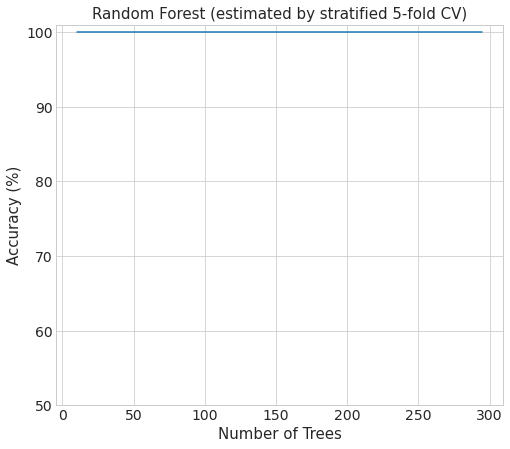

In [116]:
# Plotting the results and adjusting parameters of the plot
with plt.style.context('seaborn-whitegrid'):
    f, ax = plt.subplots(figsize=(8,7))

    plt.plot(param, test_score*100)

    plt.ylabel('Accuracy (%)', fontsize = 15)
    plt.xlabel('Number of Trees', fontsize = 15)
    plt.ylim(50,101)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Random Forest (estimated by stratified 5-fold CV)', fontsize=15)

In [117]:
rf_mod = ma.RF_model(treated_datasets['i_rs_cf_dist'], lbls_bin_n, return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)
print(rf_mod['cv_scores'])

{'fit_time': array([0.80550265, 0.7370224 , 0.77078843, 0.77142262, 0.84211445]), 'score_time': array([0.03516364, 0.03499842, 0.03388691, 0.0418601 , 0.03986669]), 'test_score': array([1., 1., 1., 1., 1.])}


In [118]:
rf_mod['model'].score(t_data, t_labels)

0.0

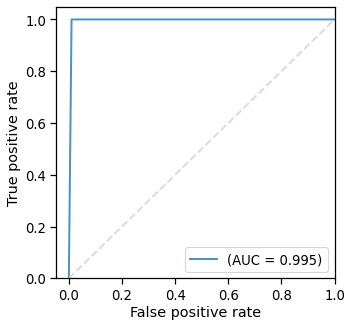

In [119]:
res = ma.RF_ROC_cv(treated_datasets['i_rs_cf_dist'], lbls_bin_n, 1, n_fold=5, n_trees=200, n_iter=50)

with sns.plotting_context("notebook", font_scale=1.2):
    f, ax = plt.subplots(1, 1, figsize=(5,5))
    mean_fpr = res['average fpr']
    mean_tpr = res['average tpr']
    mean_auc = res['mean AUC']
    ax.plot(mean_fpr, mean_tpr,
           label=f'(AUC = {mean_auc:.3f})',
           lw=2, alpha=0.8)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
    ax.legend()
    ax.set_xlim(None,1)
    ax.set_ylim(0,None)
    ax.set(xlabel='False positive rate', ylabel='True positive rate', title='')
          # title="Random forest ROC curves for Vitis types data set")
    plt.show()

PLS-DA Tests

In [120]:
optim_pls = ma.optim_PLSDA_n_components(arti_data, arti_data_labels, encode2as1vector=True, max_comp=20, n_fold=5).CVscores

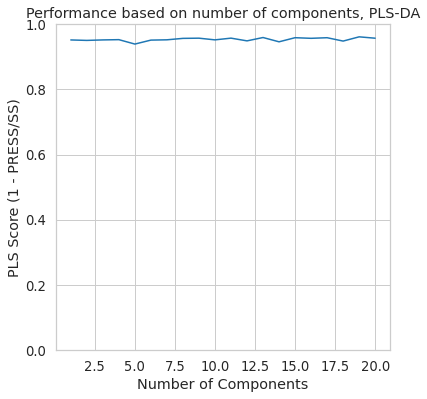

In [121]:
# Plotting the results and adjusting plot parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (6,6))
        
        ax.plot(range(1, len(optim_pls) + 1), optim_pls)
        ax.set(xlabel='Number of Components',
                ylabel='PLS Score (1 - PRESS/SS)',
                title='Performance based on number of components, PLS-DA')
        ax.set_ylim([0, 1])

In [122]:
cv_plsda_model = ma.PLSDA_model_CV(treated_datasets['i_rs_cf_dist'], lbls_bin_n, n_comp=4,
                   n_fold=5, iter_num=20,
                   encode2as1vector=True, feat_type='Coef')

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [123]:
np.mean(cv_plsda_model['accuracy'])

1.0

In [124]:
t_labels

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=uint8)

**This gives 0 accuracy, thus, discrimination is happenning perfectly but backwards.**

In [125]:
plsda = ma.fit_PLSDA_model(treated_datasets['i_rs_cf_dist'], lbls_bin_n, n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the test group
y_pred = plsda.predict(t_data)
print(y_pred)

# Decision rule for classification
# Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
# In case of 1,0 encoding for two groups, round to nearest integer to compare
nright = 0
rounded = np.round(y_pred)
for i in range(len(y_pred)):
    if rounded[i] == t_labels[i]:
        nright += 1  # Correct prediction


# Calculate accuracy for this iteration
accuracy = (nright / len(t_labels))
print(accuracy)

[[-0.19453505]
 [-0.21295322]
 [-0.01915225]
 [ 0.99297869]
 [ 1.05630404]
 [ 1.07716773]
 [ 0.0608071 ]
 [ 0.05139987]
 [ 0.0306052 ]
 [ 1.19759638]
 [ 1.22769781]
 [ 1.20644418]
 [ 1.10685961]
 [ 1.03107142]
 [ 0.95583076]
 [-0.04686483]
 [ 0.08890774]
 [ 0.14781678]
 [ 1.13019476]
 [ 1.12453435]
 [ 1.1626248 ]
 [ 0.00729014]
 [ 0.24161788]
 [ 0.10987426]
 [ 0.00556639]
 [ 0.18964464]
 [-0.01534005]
 [-0.02649698]
 [-0.06647108]
 [-0.03833279]
 [ 1.0854467 ]
 [ 0.84267215]
 [ 0.98919286]]
1.0


In [126]:
t_labels

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=uint8)

In [127]:
t_labels_2 = []
for i in t_labels:
    if i==1:
        t_labels_2.append('vinifera')
    else:
        t_labels_2.append('wild')

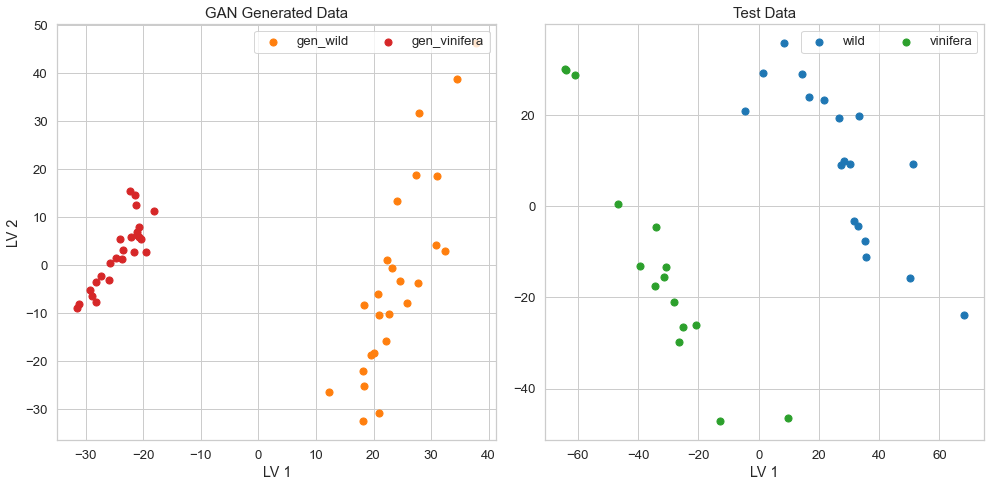

In [128]:
n_components = 4

#t_labels_2 = ['vinifera' for i in true_labels[-3*batch_size:] if i==0 else 'wild']


model, scores = ma.fit_PLSDA_model(arti_data, arti_data_lbls, n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(t_data, t_labels_2, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="GAN Generated Data", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        gem.plot_PLS(scores2, lcolors, title="Test Data", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=2)       
        axl.legend(loc='upper right', ncol=2)       
        plt.tight_layout()
        plt.show()

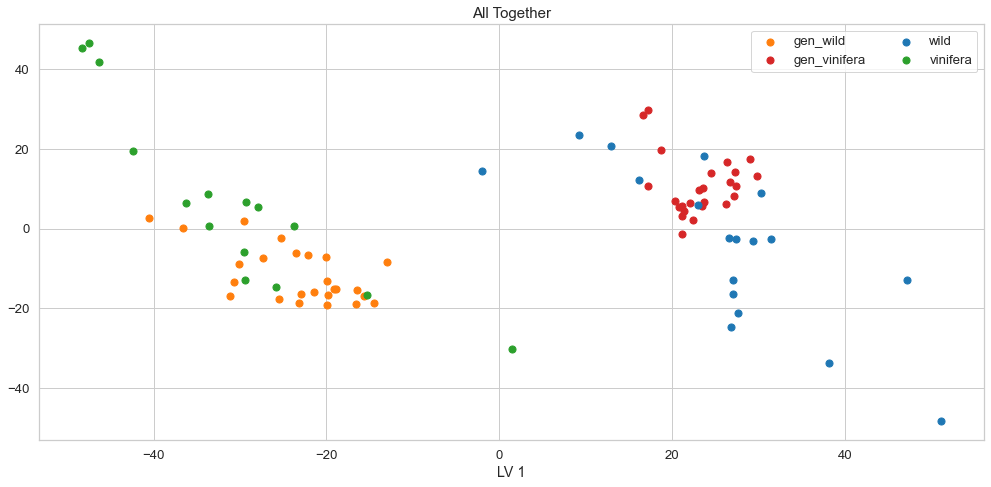

In [129]:
n_components = 4

df_temp = pd.concat([arti_data, t_data])
labels_temp = arti_data_lbls + t_labels_2

model, scores = ma.fit_PLSDA_model(df_temp, labels_temp, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="All Together", ax=ax)

        ax.set_ylabel('')
        ax.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

### Sample Correlation Matrix

Between samples of the real data and a set of generated artificial samples of GANs

In [130]:
# Real Data, organize it to have first all samples of a class, then all samples of the other class
df = datasets['vitis_types']['NGP'].copy()

samp = df.index
tg = datasets['vitis_types']['target'].copy()
new_order = [x for _, x in sorted(zip(tg, samp))]
new_tg = [x for x, _ in sorted(zip(tg, samp))]

df = df.loc[new_order]
#df

In [131]:
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=treated_datasets['i_rs_cf_dist'].index, columns=df.index).astype('float')

for i in df.index:
    for j in treated_datasets['i_rs_cf_dist'].index:
        correlations.loc[j,i] = stats.spearmanr(df.loc[i],
                                               treated_datasets['i_rs_cf_dist'].loc[j])[0]
        
correlations.columns = new_tg
correlations.index = ['wild_gen']*(len(treated_datasets['i_rs_cf_dist'])//2) + ['vinifera_gen']*(len(
    treated_datasets['i_rs_cf_dist'])//2)

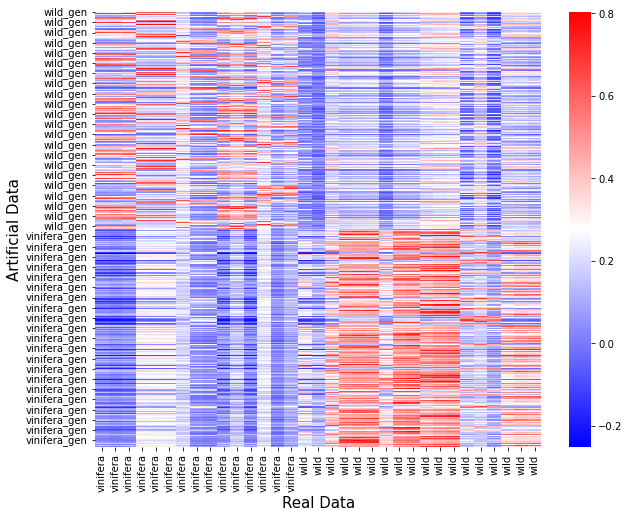

In [132]:
# Draw the heatmap
f, ax = plt.subplots(figsize=(10,8))

g = sns.heatmap(correlations, cmap='bwr')
ax.set_ylabel('Artificial Data', fontsize=15)
ax.set_xlabel('Real Data', fontsize=15)

plt.show()

C:\Users\franc\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


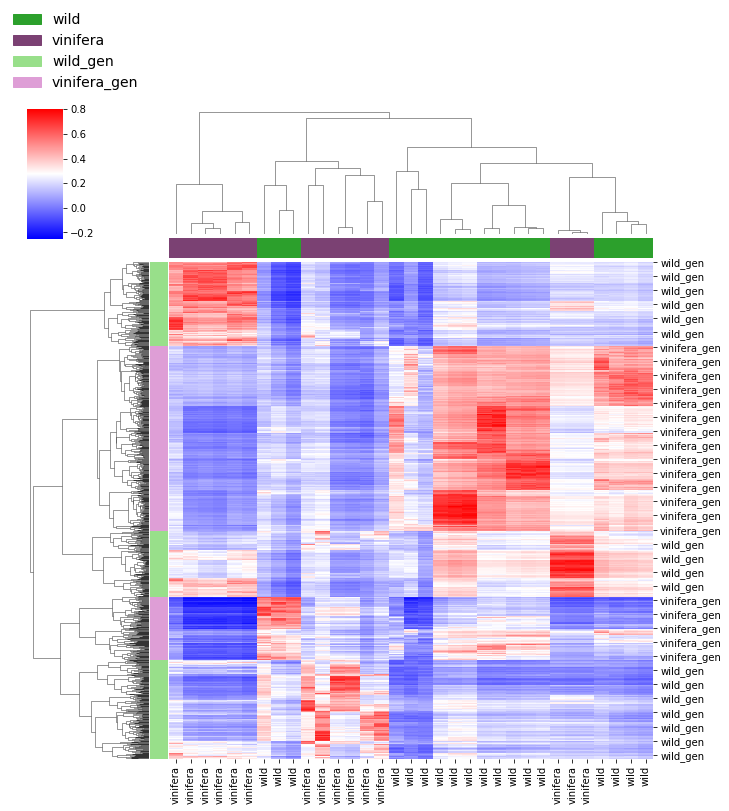

In [133]:
# Draw the heatmap
#f, ax = plt.subplots(figsize=(10,8))
import matplotlib.patches as mpatches

row_cols = [label_colors[lbl] for lbl in new_tg]
row_cols2 = [label_colors[lbl] for lbl in correlations.index]
g = sns.clustermap(correlations, col_colors=row_cols, cmap='bwr', row_colors= row_cols2)
# some tweaks
patches = []
for lbl in ('wild', 'vinifera', 'wild_gen', 'vinifera_gen'):
    patches.append(mpatches.Patch(color=label_colors[lbl], label=lbl))
leg = plt.legend(handles=patches, loc=3, bbox_to_anchor=(-0.75, 1.05, 0.5, 1),
                     frameon=False, fontsize=14) 
#g.ylabel('Artificial Data', fontsize=15)
#g.set_xlabel('Real Data', fontsize=15)

plt.show()